In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "fsv2"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 296
Categorical features: 5
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 368
Categorical Columns: 5


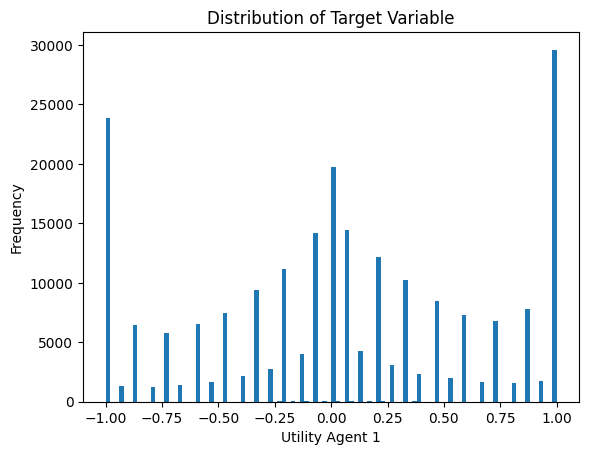

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.495407


[200]	valid_0's rmse: 0.480155


[300]	valid_0's rmse: 0.470501


[400]	valid_0's rmse: 0.46578


[500]	valid_0's rmse: 0.461113


[600]	valid_0's rmse: 0.457182


[700]	valid_0's rmse: 0.454033


[800]	valid_0's rmse: 0.451527


[900]	valid_0's rmse: 0.449413


[1000]	valid_0's rmse: 0.44727


[1100]	valid_0's rmse: 0.445533


[1200]	valid_0's rmse: 0.444379


[1300]	valid_0's rmse: 0.443309


[1400]	valid_0's rmse: 0.44205


[1500]	valid_0's rmse: 0.441203


[1600]	valid_0's rmse: 0.440435


[1700]	valid_0's rmse: 0.439876


[1800]	valid_0's rmse: 0.439273


[1900]	valid_0's rmse: 0.438736


[2000]	valid_0's rmse: 0.438138


[2100]	valid_0's rmse: 0.437635


[2200]	valid_0's rmse: 0.437263


[2300]	valid_0's rmse: 0.436866


[2400]	valid_0's rmse: 0.436485


[2500]	valid_0's rmse: 0.436228


[2600]	valid_0's rmse: 0.435938


[2700]	valid_0's rmse: 0.435712


[2800]	valid_0's rmse: 0.435472


[2900]	valid_0's rmse: 0.435268


[3000]	valid_0's rmse: 0.43512


[3100]	valid_0's rmse: 0.434908


[3200]	valid_0's rmse: 0.434717


[3300]	valid_0's rmse: 0.434462


[3400]	valid_0's rmse: 0.43432


[3500]	valid_0's rmse: 0.43419


[3600]	valid_0's rmse: 0.434086


[3700]	valid_0's rmse: 0.433912


[3800]	valid_0's rmse: 0.433739


[3900]	valid_0's rmse: 0.433588


[4000]	valid_0's rmse: 0.433519


[4100]	valid_0's rmse: 0.433341


[4200]	valid_0's rmse: 0.433197


[4300]	valid_0's rmse: 0.433093


[4400]	valid_0's rmse: 0.433003


[4500]	valid_0's rmse: 0.432937


[4600]	valid_0's rmse: 0.43289


[4700]	valid_0's rmse: 0.432823


[4800]	valid_0's rmse: 0.432742


[4900]	valid_0's rmse: 0.432723


[5000]	valid_0's rmse: 0.432727


[5100]	valid_0's rmse: 0.432668


[5200]	valid_0's rmse: 0.432588


[5300]	valid_0's rmse: 0.432443


[5400]	valid_0's rmse: 0.432367


[5500]	valid_0's rmse: 0.432279


[5600]	valid_0's rmse: 0.432265


[5700]	valid_0's rmse: 0.432201


[5800]	valid_0's rmse: 0.43217


[5900]	valid_0's rmse: 0.432149


[6000]	valid_0's rmse: 0.432126


[6100]	valid_0's rmse: 0.432104


[6200]	valid_0's rmse: 0.432032


[6300]	valid_0's rmse: 0.431993


[6400]	valid_0's rmse: 0.431941


[6500]	valid_0's rmse: 0.431876


[6600]	valid_0's rmse: 0.431838


[6700]	valid_0's rmse: 0.431798


[6800]	valid_0's rmse: 0.431756


[6900]	valid_0's rmse: 0.431717


[7000]	valid_0's rmse: 0.431709


[7100]	valid_0's rmse: 0.431626


[7200]	valid_0's rmse: 0.431686


[7300]	valid_0's rmse: 0.431669


[7400]	valid_0's rmse: 0.43157


[7500]	valid_0's rmse: 0.431523


[7600]	valid_0's rmse: 0.431497


[7700]	valid_0's rmse: 0.431441


[7800]	valid_0's rmse: 0.431416


[7900]	valid_0's rmse: 0.431336


[8000]	valid_0's rmse: 0.431382


[8100]	valid_0's rmse: 0.43135


[8200]	valid_0's rmse: 0.431357


[8300]	valid_0's rmse: 0.431345


[8400]	valid_0's rmse: 0.431367


[8500]	valid_0's rmse: 0.431339


[8600]	valid_0's rmse: 0.43134


[8700]	valid_0's rmse: 0.431348


[8800]	valid_0's rmse: 0.431311


[8900]	valid_0's rmse: 0.431345


[9000]	valid_0's rmse: 0.431366


[9100]	valid_0's rmse: 0.431293


[9200]	valid_0's rmse: 0.431265


[9300]	valid_0's rmse: 0.431248


[9400]	valid_0's rmse: 0.431263


[9500]	valid_0's rmse: 0.431255


[9600]	valid_0's rmse: 0.431224


[9700]	valid_0's rmse: 0.431196


[9800]	valid_0's rmse: 0.431209


[9900]	valid_0's rmse: 0.431186


[10000]	valid_0's rmse: 0.431182


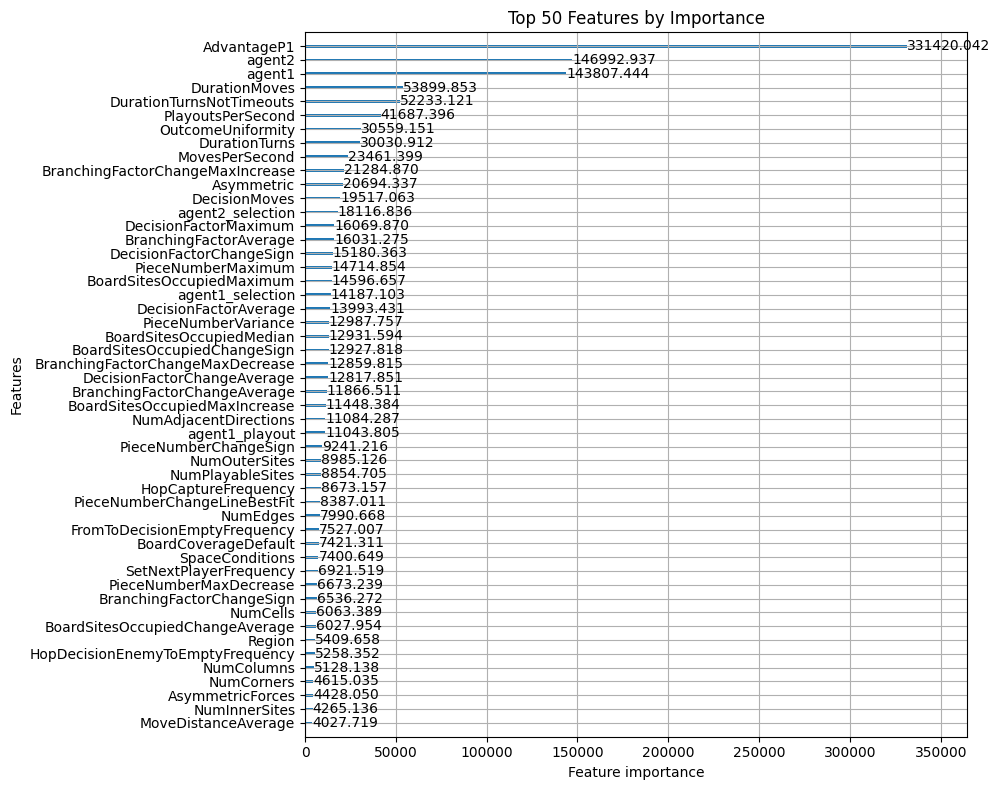

Fold 1 - RMSE: 0.4306652567053851
Fold 2


[100]	valid_0's rmse: 0.505532


[200]	valid_0's rmse: 0.486297


[300]	valid_0's rmse: 0.476293


[400]	valid_0's rmse: 0.470596


[500]	valid_0's rmse: 0.466295


[600]	valid_0's rmse: 0.463527


[700]	valid_0's rmse: 0.461511


[800]	valid_0's rmse: 0.459499


[900]	valid_0's rmse: 0.458351


[1000]	valid_0's rmse: 0.456897


[1100]	valid_0's rmse: 0.455708


[1200]	valid_0's rmse: 0.454641


[1300]	valid_0's rmse: 0.45355


[1400]	valid_0's rmse: 0.45242


[1500]	valid_0's rmse: 0.451924


[1600]	valid_0's rmse: 0.45124


[1700]	valid_0's rmse: 0.450714


[1800]	valid_0's rmse: 0.450127


[1900]	valid_0's rmse: 0.44957


[2000]	valid_0's rmse: 0.449114


[2100]	valid_0's rmse: 0.448783


[2200]	valid_0's rmse: 0.448422


[2300]	valid_0's rmse: 0.448136


[2400]	valid_0's rmse: 0.447799


[2500]	valid_0's rmse: 0.447512


[2600]	valid_0's rmse: 0.447226


[2700]	valid_0's rmse: 0.44682


[2800]	valid_0's rmse: 0.446592


[2900]	valid_0's rmse: 0.446338


[3000]	valid_0's rmse: 0.446099


[3100]	valid_0's rmse: 0.445879


[3200]	valid_0's rmse: 0.445621


[3300]	valid_0's rmse: 0.445506


[3400]	valid_0's rmse: 0.445248


[3500]	valid_0's rmse: 0.445065


[3600]	valid_0's rmse: 0.444848


[3700]	valid_0's rmse: 0.444635


[3800]	valid_0's rmse: 0.444355


[3900]	valid_0's rmse: 0.444133


[4000]	valid_0's rmse: 0.444014


[4100]	valid_0's rmse: 0.443886


[4200]	valid_0's rmse: 0.443792


[4300]	valid_0's rmse: 0.443548


[4400]	valid_0's rmse: 0.443437


[4500]	valid_0's rmse: 0.443352


[4600]	valid_0's rmse: 0.443156


[4700]	valid_0's rmse: 0.443016


[4800]	valid_0's rmse: 0.442919


[4900]	valid_0's rmse: 0.442754


[5000]	valid_0's rmse: 0.442643


[5100]	valid_0's rmse: 0.442561


[5200]	valid_0's rmse: 0.442502


[5300]	valid_0's rmse: 0.442483


[5400]	valid_0's rmse: 0.442414


[5500]	valid_0's rmse: 0.442349


[5600]	valid_0's rmse: 0.442234


[5700]	valid_0's rmse: 0.442244


[5800]	valid_0's rmse: 0.442082


[5900]	valid_0's rmse: 0.441985


[6000]	valid_0's rmse: 0.441879


[6100]	valid_0's rmse: 0.441758


[6200]	valid_0's rmse: 0.44169


[6300]	valid_0's rmse: 0.441618


[6400]	valid_0's rmse: 0.441535


[6500]	valid_0's rmse: 0.441484


[6600]	valid_0's rmse: 0.441373


[6700]	valid_0's rmse: 0.441268


[6800]	valid_0's rmse: 0.44121


[6900]	valid_0's rmse: 0.441168


[7000]	valid_0's rmse: 0.441036


[7100]	valid_0's rmse: 0.441019


[7200]	valid_0's rmse: 0.440943


[7300]	valid_0's rmse: 0.440981


[7400]	valid_0's rmse: 0.440975


[7500]	valid_0's rmse: 0.440901


[7600]	valid_0's rmse: 0.440864


[7700]	valid_0's rmse: 0.440879


[7800]	valid_0's rmse: 0.440803


[7900]	valid_0's rmse: 0.440737


[8000]	valid_0's rmse: 0.440743


[8100]	valid_0's rmse: 0.440756


[8200]	valid_0's rmse: 0.4407


[8300]	valid_0's rmse: 0.44067


[8400]	valid_0's rmse: 0.440629


[8500]	valid_0's rmse: 0.440634


[8600]	valid_0's rmse: 0.440643


[8700]	valid_0's rmse: 0.440641


[8800]	valid_0's rmse: 0.44056


[8900]	valid_0's rmse: 0.440516


[9000]	valid_0's rmse: 0.440423


[9100]	valid_0's rmse: 0.440392


[9200]	valid_0's rmse: 0.440309


[9300]	valid_0's rmse: 0.440246


[9400]	valid_0's rmse: 0.440207


[9500]	valid_0's rmse: 0.440156


[9600]	valid_0's rmse: 0.440126


[9700]	valid_0's rmse: 0.440095


[9800]	valid_0's rmse: 0.440114


[9900]	valid_0's rmse: 0.440049


[10000]	valid_0's rmse: 0.440058


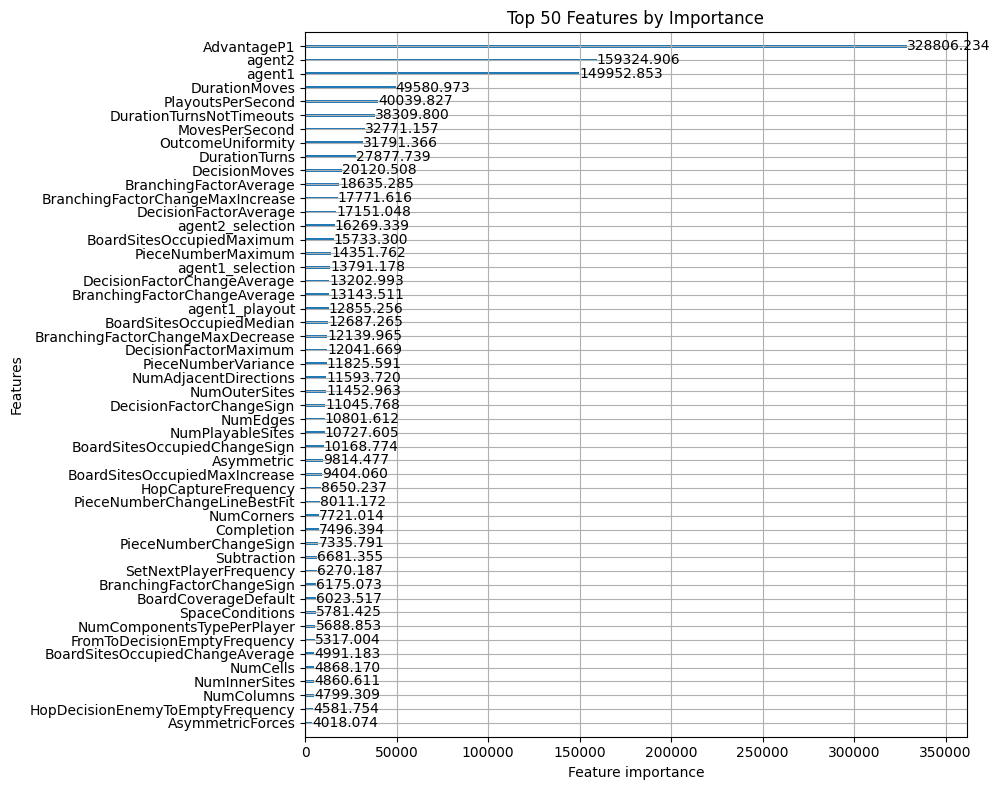

Fold 2 - RMSE: 0.4395851249544506
Fold 3


[100]	valid_0's rmse: 0.517338


[200]	valid_0's rmse: 0.488432


[300]	valid_0's rmse: 0.476191


[400]	valid_0's rmse: 0.468197


[500]	valid_0's rmse: 0.463979


[600]	valid_0's rmse: 0.460605


[700]	valid_0's rmse: 0.458307


[800]	valid_0's rmse: 0.455847


[900]	valid_0's rmse: 0.453787


[1000]	valid_0's rmse: 0.4519


[1100]	valid_0's rmse: 0.450438


[1200]	valid_0's rmse: 0.44941


[1300]	valid_0's rmse: 0.448357


[1400]	valid_0's rmse: 0.447455


[1500]	valid_0's rmse: 0.446677


[1600]	valid_0's rmse: 0.445921


[1700]	valid_0's rmse: 0.445327


[1800]	valid_0's rmse: 0.444693


[1900]	valid_0's rmse: 0.444169


[2000]	valid_0's rmse: 0.443694


[2100]	valid_0's rmse: 0.443192


[2200]	valid_0's rmse: 0.442882


[2300]	valid_0's rmse: 0.442398


[2400]	valid_0's rmse: 0.442064


[2500]	valid_0's rmse: 0.44177


[2600]	valid_0's rmse: 0.441641


[2700]	valid_0's rmse: 0.441385


[2800]	valid_0's rmse: 0.441064


[2900]	valid_0's rmse: 0.440866


[3000]	valid_0's rmse: 0.440549


[3100]	valid_0's rmse: 0.440254


[3200]	valid_0's rmse: 0.440121


[3300]	valid_0's rmse: 0.439961


[3400]	valid_0's rmse: 0.43968


[3500]	valid_0's rmse: 0.439418


[3600]	valid_0's rmse: 0.439252


[3700]	valid_0's rmse: 0.439134


[3800]	valid_0's rmse: 0.43897


[3900]	valid_0's rmse: 0.438785


[4000]	valid_0's rmse: 0.438644


[4100]	valid_0's rmse: 0.438507


[4200]	valid_0's rmse: 0.438365


[4300]	valid_0's rmse: 0.438235


[4400]	valid_0's rmse: 0.438155


[4500]	valid_0's rmse: 0.437973


[4600]	valid_0's rmse: 0.437914


[4700]	valid_0's rmse: 0.437838


[4800]	valid_0's rmse: 0.437754


[4900]	valid_0's rmse: 0.437641


[5000]	valid_0's rmse: 0.437593


[5100]	valid_0's rmse: 0.437473


[5200]	valid_0's rmse: 0.437412


[5300]	valid_0's rmse: 0.437331


[5400]	valid_0's rmse: 0.437242


[5500]	valid_0's rmse: 0.437128


[5600]	valid_0's rmse: 0.43701


[5700]	valid_0's rmse: 0.436919


[5800]	valid_0's rmse: 0.43685


[5900]	valid_0's rmse: 0.436785


[6000]	valid_0's rmse: 0.436684


[6100]	valid_0's rmse: 0.436611


[6200]	valid_0's rmse: 0.43659


[6300]	valid_0's rmse: 0.436511


[6400]	valid_0's rmse: 0.436469


[6500]	valid_0's rmse: 0.436355


[6600]	valid_0's rmse: 0.436246


[6700]	valid_0's rmse: 0.436181


[6800]	valid_0's rmse: 0.436116


[6900]	valid_0's rmse: 0.436089


[7000]	valid_0's rmse: 0.436028


[7100]	valid_0's rmse: 0.435968


[7200]	valid_0's rmse: 0.43593


[7300]	valid_0's rmse: 0.435907


[7400]	valid_0's rmse: 0.435855


[7500]	valid_0's rmse: 0.435869


[7600]	valid_0's rmse: 0.435847


[7700]	valid_0's rmse: 0.435819


[7800]	valid_0's rmse: 0.43581


[7900]	valid_0's rmse: 0.435824


[8000]	valid_0's rmse: 0.435853


[8100]	valid_0's rmse: 0.435787


[8200]	valid_0's rmse: 0.435732


[8300]	valid_0's rmse: 0.435653


[8400]	valid_0's rmse: 0.435602


[8500]	valid_0's rmse: 0.435544


[8600]	valid_0's rmse: 0.435525


[8700]	valid_0's rmse: 0.435488


[8800]	valid_0's rmse: 0.435511


[8900]	valid_0's rmse: 0.435537


[9000]	valid_0's rmse: 0.435493


[9100]	valid_0's rmse: 0.435415


[9200]	valid_0's rmse: 0.435391


[9300]	valid_0's rmse: 0.435368


[9400]	valid_0's rmse: 0.435358


[9500]	valid_0's rmse: 0.435357


[9600]	valid_0's rmse: 0.435324


[9700]	valid_0's rmse: 0.435292


[9800]	valid_0's rmse: 0.435221


[9900]	valid_0's rmse: 0.435208


[10000]	valid_0's rmse: 0.435197


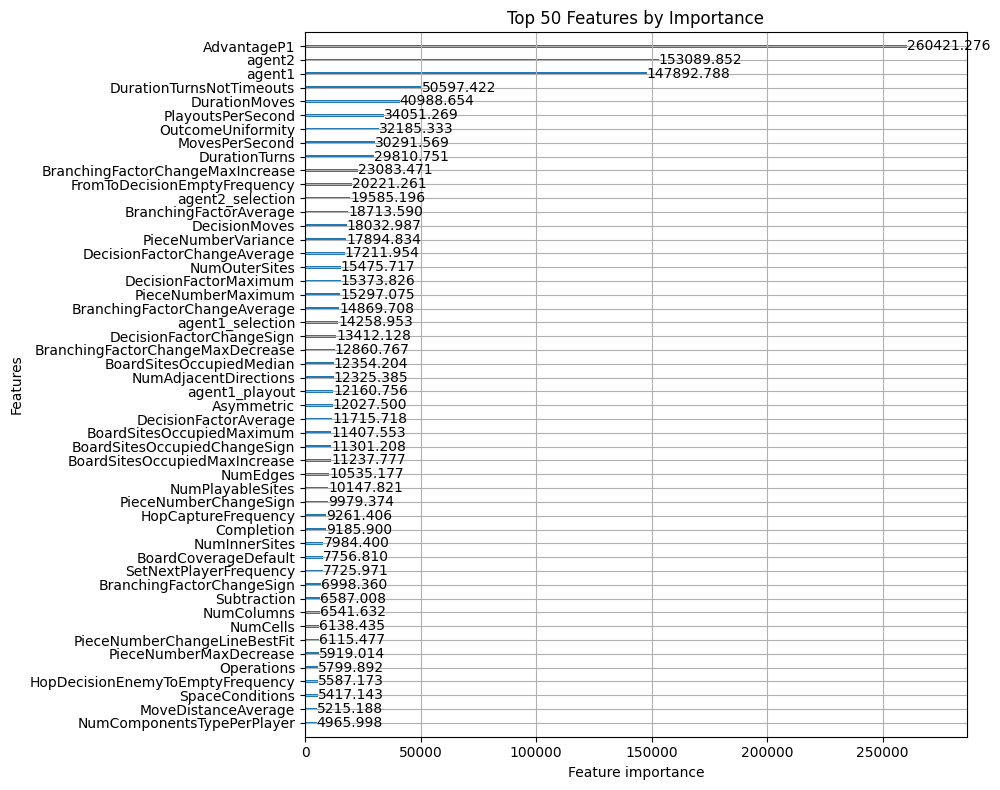

Fold 3 - RMSE: 0.43457403713642967
Fold 4


[100]	valid_0's rmse: 0.512867


[200]	valid_0's rmse: 0.491018


[300]	valid_0's rmse: 0.479072


[400]	valid_0's rmse: 0.470806


[500]	valid_0's rmse: 0.465709


[600]	valid_0's rmse: 0.461691


[700]	valid_0's rmse: 0.458599


[800]	valid_0's rmse: 0.45596


[900]	valid_0's rmse: 0.453871


[1000]	valid_0's rmse: 0.451599


[1100]	valid_0's rmse: 0.449966


[1200]	valid_0's rmse: 0.448325


[1300]	valid_0's rmse: 0.447145


[1400]	valid_0's rmse: 0.446003


[1500]	valid_0's rmse: 0.44489


[1600]	valid_0's rmse: 0.444148


[1700]	valid_0's rmse: 0.443401


[1800]	valid_0's rmse: 0.442845


[1900]	valid_0's rmse: 0.442121


[2000]	valid_0's rmse: 0.441463


[2100]	valid_0's rmse: 0.440946


[2200]	valid_0's rmse: 0.440365


[2300]	valid_0's rmse: 0.439911


[2400]	valid_0's rmse: 0.439544


[2500]	valid_0's rmse: 0.439158


[2600]	valid_0's rmse: 0.438863


[2700]	valid_0's rmse: 0.438603


[2800]	valid_0's rmse: 0.43827


[2900]	valid_0's rmse: 0.437905


[3000]	valid_0's rmse: 0.437645


[3100]	valid_0's rmse: 0.437442


[3200]	valid_0's rmse: 0.437255


[3300]	valid_0's rmse: 0.43704


[3400]	valid_0's rmse: 0.436898


[3500]	valid_0's rmse: 0.436811


[3600]	valid_0's rmse: 0.43674


[3700]	valid_0's rmse: 0.436557


[3800]	valid_0's rmse: 0.436361


[3900]	valid_0's rmse: 0.436106


[4000]	valid_0's rmse: 0.436011


[4100]	valid_0's rmse: 0.435872


[4200]	valid_0's rmse: 0.4357


[4300]	valid_0's rmse: 0.435541


[4400]	valid_0's rmse: 0.435329


[4500]	valid_0's rmse: 0.435224


[4600]	valid_0's rmse: 0.435064


[4700]	valid_0's rmse: 0.434935


[4800]	valid_0's rmse: 0.434795


[4900]	valid_0's rmse: 0.434628


[5000]	valid_0's rmse: 0.434519


[5100]	valid_0's rmse: 0.434437


[5200]	valid_0's rmse: 0.434303


[5300]	valid_0's rmse: 0.434137


[5400]	valid_0's rmse: 0.43409


[5500]	valid_0's rmse: 0.434039


[5600]	valid_0's rmse: 0.43393


[5700]	valid_0's rmse: 0.433815


[5800]	valid_0's rmse: 0.433741


[5900]	valid_0's rmse: 0.433687


[6000]	valid_0's rmse: 0.433625


[6100]	valid_0's rmse: 0.433503


[6200]	valid_0's rmse: 0.433418


[6300]	valid_0's rmse: 0.433392


[6400]	valid_0's rmse: 0.433352


[6500]	valid_0's rmse: 0.433277


[6600]	valid_0's rmse: 0.433204


[6700]	valid_0's rmse: 0.43324


[6800]	valid_0's rmse: 0.433141


[6900]	valid_0's rmse: 0.433127


[7000]	valid_0's rmse: 0.433077


[7100]	valid_0's rmse: 0.433025


[7200]	valid_0's rmse: 0.432999


[7300]	valid_0's rmse: 0.432978


[7400]	valid_0's rmse: 0.432945


[7500]	valid_0's rmse: 0.432967


[7600]	valid_0's rmse: 0.432921


[7700]	valid_0's rmse: 0.432886


[7800]	valid_0's rmse: 0.432847


[7900]	valid_0's rmse: 0.43288


[8000]	valid_0's rmse: 0.432853


[8100]	valid_0's rmse: 0.432789


[8200]	valid_0's rmse: 0.432772


[8300]	valid_0's rmse: 0.432763


[8400]	valid_0's rmse: 0.432706


[8500]	valid_0's rmse: 0.432622


[8600]	valid_0's rmse: 0.432547


[8700]	valid_0's rmse: 0.432545


[8800]	valid_0's rmse: 0.432498


[8900]	valid_0's rmse: 0.432445


[9000]	valid_0's rmse: 0.432403


[9100]	valid_0's rmse: 0.432401


[9200]	valid_0's rmse: 0.432358


[9300]	valid_0's rmse: 0.432315


[9400]	valid_0's rmse: 0.43223


[9500]	valid_0's rmse: 0.432148


[9600]	valid_0's rmse: 0.432077


[9700]	valid_0's rmse: 0.432037


[9800]	valid_0's rmse: 0.431991


[9900]	valid_0's rmse: 0.431981


[10000]	valid_0's rmse: 0.432019


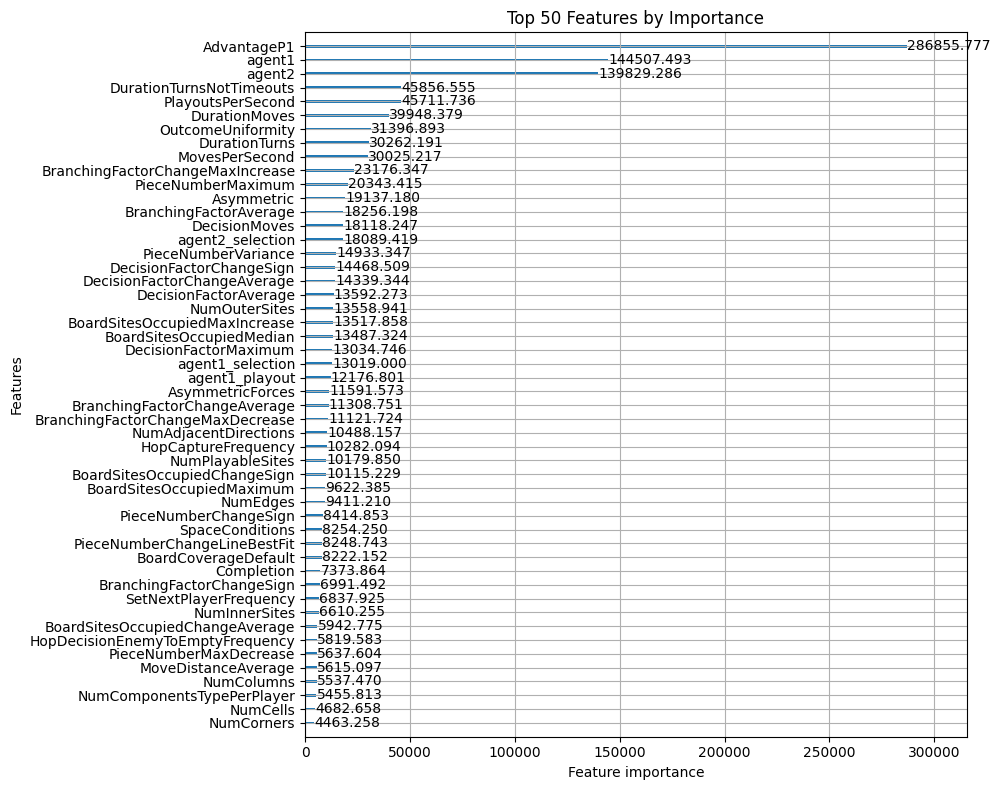

Fold 4 - RMSE: 0.4312490861225702
Fold 5


[100]	valid_0's rmse: 0.48467


[200]	valid_0's rmse: 0.461909


[300]	valid_0's rmse: 0.448578


[400]	valid_0's rmse: 0.439412


[500]	valid_0's rmse: 0.433587


[600]	valid_0's rmse: 0.429335


[700]	valid_0's rmse: 0.425661


[800]	valid_0's rmse: 0.42365


[900]	valid_0's rmse: 0.421192


[1000]	valid_0's rmse: 0.419208


[1100]	valid_0's rmse: 0.41737


[1200]	valid_0's rmse: 0.416356


[1300]	valid_0's rmse: 0.415341


[1400]	valid_0's rmse: 0.414062


[1500]	valid_0's rmse: 0.412957


[1600]	valid_0's rmse: 0.411986


[1700]	valid_0's rmse: 0.411364


[1800]	valid_0's rmse: 0.410756


[1900]	valid_0's rmse: 0.410014


[2000]	valid_0's rmse: 0.409486


[2100]	valid_0's rmse: 0.409047


[2200]	valid_0's rmse: 0.408692


[2300]	valid_0's rmse: 0.408111


[2400]	valid_0's rmse: 0.407603


[2500]	valid_0's rmse: 0.40732


[2600]	valid_0's rmse: 0.407076


[2700]	valid_0's rmse: 0.406715


[2800]	valid_0's rmse: 0.406483


[2900]	valid_0's rmse: 0.406228


[3000]	valid_0's rmse: 0.405933


[3100]	valid_0's rmse: 0.405567


[3200]	valid_0's rmse: 0.405221


[3300]	valid_0's rmse: 0.405009


[3400]	valid_0's rmse: 0.40485


[3500]	valid_0's rmse: 0.404665


[3600]	valid_0's rmse: 0.404486


[3700]	valid_0's rmse: 0.404292


[3800]	valid_0's rmse: 0.404061


[3900]	valid_0's rmse: 0.403914


[4000]	valid_0's rmse: 0.403653


[4100]	valid_0's rmse: 0.403503


[4200]	valid_0's rmse: 0.403319


[4300]	valid_0's rmse: 0.403228


[4400]	valid_0's rmse: 0.403092


[4500]	valid_0's rmse: 0.402984


[4600]	valid_0's rmse: 0.402778


[4700]	valid_0's rmse: 0.402669


[4800]	valid_0's rmse: 0.402605


[4900]	valid_0's rmse: 0.40253


[5000]	valid_0's rmse: 0.402425


[5100]	valid_0's rmse: 0.402281


[5200]	valid_0's rmse: 0.402231


[5300]	valid_0's rmse: 0.40219


[5400]	valid_0's rmse: 0.402132


[5500]	valid_0's rmse: 0.40212


[5600]	valid_0's rmse: 0.401974


[5700]	valid_0's rmse: 0.401864


[5800]	valid_0's rmse: 0.401768


[5900]	valid_0's rmse: 0.401675


[6000]	valid_0's rmse: 0.401699


[6100]	valid_0's rmse: 0.401719


[6200]	valid_0's rmse: 0.401621


[6300]	valid_0's rmse: 0.401553


[6400]	valid_0's rmse: 0.401473


[6500]	valid_0's rmse: 0.401376


[6600]	valid_0's rmse: 0.401318


[6700]	valid_0's rmse: 0.401308


[6800]	valid_0's rmse: 0.401293


[6900]	valid_0's rmse: 0.401175


[7000]	valid_0's rmse: 0.401149


[7100]	valid_0's rmse: 0.401098


[7200]	valid_0's rmse: 0.401077


[7300]	valid_0's rmse: 0.401061


[7400]	valid_0's rmse: 0.401012


[7500]	valid_0's rmse: 0.40101


[7600]	valid_0's rmse: 0.400931


[7700]	valid_0's rmse: 0.400852


[7800]	valid_0's rmse: 0.400832


[7900]	valid_0's rmse: 0.400774


[8000]	valid_0's rmse: 0.400802


[8100]	valid_0's rmse: 0.400761


[8200]	valid_0's rmse: 0.400702


[8300]	valid_0's rmse: 0.400694


[8400]	valid_0's rmse: 0.400673


[8500]	valid_0's rmse: 0.400623


[8600]	valid_0's rmse: 0.400578


[8700]	valid_0's rmse: 0.40054


[8800]	valid_0's rmse: 0.400544


[8900]	valid_0's rmse: 0.400531


[9000]	valid_0's rmse: 0.400529


[9100]	valid_0's rmse: 0.400537


[9200]	valid_0's rmse: 0.400542


[9300]	valid_0's rmse: 0.400545


[9400]	valid_0's rmse: 0.400515


[9500]	valid_0's rmse: 0.400499


[9600]	valid_0's rmse: 0.400496


[9700]	valid_0's rmse: 0.400456


[9800]	valid_0's rmse: 0.400457


[9900]	valid_0's rmse: 0.400465


[10000]	valid_0's rmse: 0.400473


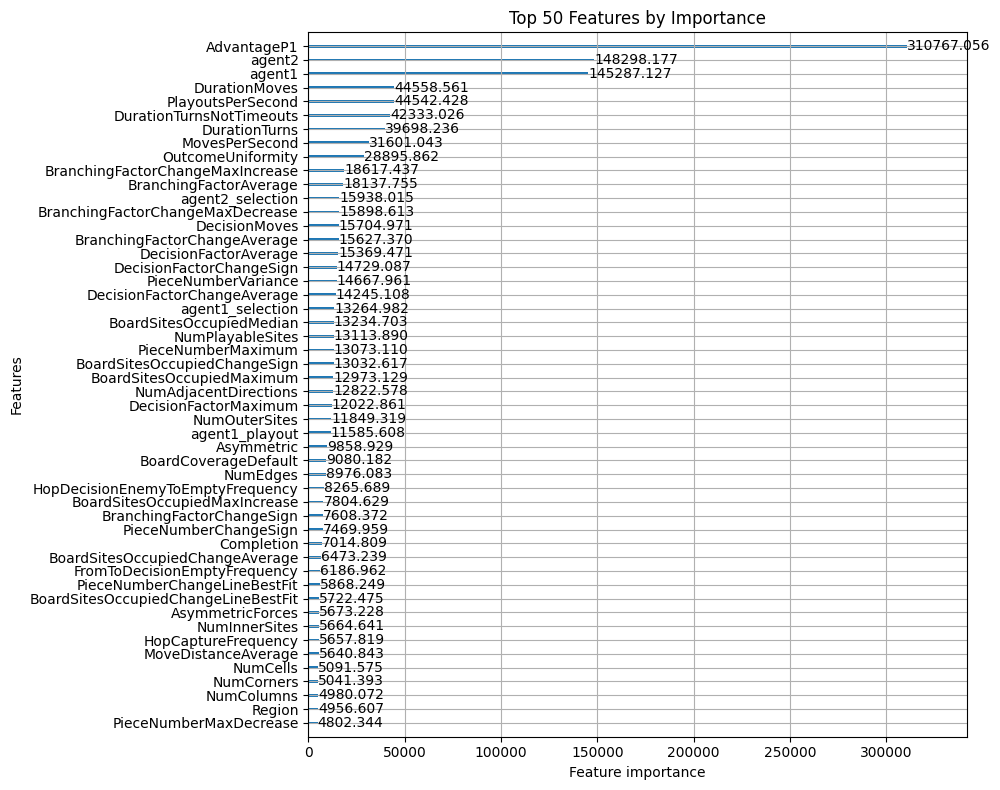

Fold 5 - RMSE: 0.39999203936294264
List of oof scores: [0.4306652567053851, 0.4395851249544506, 0.43457403713642967, 0.4312490861225702, 0.39999203936294264]
Average oof score: 0.42721310885635566


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.476386


[200]	valid_0's rmse: 0.457683


[300]	valid_0's rmse: 0.448572


[400]	valid_0's rmse: 0.44266


[500]	valid_0's rmse: 0.439054


[600]	valid_0's rmse: 0.436021


[700]	valid_0's rmse: 0.433533


[800]	valid_0's rmse: 0.431565


[900]	valid_0's rmse: 0.430096


[1000]	valid_0's rmse: 0.428551


[1100]	valid_0's rmse: 0.427246


[1200]	valid_0's rmse: 0.426336


[1300]	valid_0's rmse: 0.425557


[1400]	valid_0's rmse: 0.424675


[1500]	valid_0's rmse: 0.423971


[1600]	valid_0's rmse: 0.423298


[1700]	valid_0's rmse: 0.422689


[1800]	valid_0's rmse: 0.422224


[1900]	valid_0's rmse: 0.421584


[2000]	valid_0's rmse: 0.42108


[2100]	valid_0's rmse: 0.420642


[2200]	valid_0's rmse: 0.420244


[2300]	valid_0's rmse: 0.419879


[2400]	valid_0's rmse: 0.419514


[2500]	valid_0's rmse: 0.419223


[2600]	valid_0's rmse: 0.418885


[2700]	valid_0's rmse: 0.418642


[2800]	valid_0's rmse: 0.418345


[2900]	valid_0's rmse: 0.418105


[3000]	valid_0's rmse: 0.417774


[3100]	valid_0's rmse: 0.417626


[3200]	valid_0's rmse: 0.417403


[3300]	valid_0's rmse: 0.417241


[3400]	valid_0's rmse: 0.416993


[3500]	valid_0's rmse: 0.4168


[3600]	valid_0's rmse: 0.416574


[3700]	valid_0's rmse: 0.416407


[3800]	valid_0's rmse: 0.416233


[3900]	valid_0's rmse: 0.416115


[4000]	valid_0's rmse: 0.416005


[4100]	valid_0's rmse: 0.415877


[4200]	valid_0's rmse: 0.415769


[4300]	valid_0's rmse: 0.415606


[4400]	valid_0's rmse: 0.415453


[4500]	valid_0's rmse: 0.415327


[4600]	valid_0's rmse: 0.415105


[4700]	valid_0's rmse: 0.414984


[4800]	valid_0's rmse: 0.414882


[4900]	valid_0's rmse: 0.414729


[5000]	valid_0's rmse: 0.4147


[5100]	valid_0's rmse: 0.414522


[5200]	valid_0's rmse: 0.414474


[5300]	valid_0's rmse: 0.414421


[5400]	valid_0's rmse: 0.414349


[5500]	valid_0's rmse: 0.414228


[5600]	valid_0's rmse: 0.414215


[5700]	valid_0's rmse: 0.414133


[5800]	valid_0's rmse: 0.413997


[5900]	valid_0's rmse: 0.413946


[6000]	valid_0's rmse: 0.413917


[6100]	valid_0's rmse: 0.413848


[6200]	valid_0's rmse: 0.413719


[6300]	valid_0's rmse: 0.413679


[6400]	valid_0's rmse: 0.413572


[6500]	valid_0's rmse: 0.413519


[6600]	valid_0's rmse: 0.413455


[6700]	valid_0's rmse: 0.413357


[6800]	valid_0's rmse: 0.413314


[6900]	valid_0's rmse: 0.413219


[7000]	valid_0's rmse: 0.413148


[7100]	valid_0's rmse: 0.413113


[7200]	valid_0's rmse: 0.413116


[7300]	valid_0's rmse: 0.413121


[7400]	valid_0's rmse: 0.413134


[7500]	valid_0's rmse: 0.413129


[7600]	valid_0's rmse: 0.413054


[7700]	valid_0's rmse: 0.412986


[7800]	valid_0's rmse: 0.412904


[7900]	valid_0's rmse: 0.412901


[8000]	valid_0's rmse: 0.412883


[8100]	valid_0's rmse: 0.412854


[8200]	valid_0's rmse: 0.412754


[8300]	valid_0's rmse: 0.412706


[8400]	valid_0's rmse: 0.412731


[8500]	valid_0's rmse: 0.412684


[8600]	valid_0's rmse: 0.412645


[8700]	valid_0's rmse: 0.412605


[8800]	valid_0's rmse: 0.412604


[8900]	valid_0's rmse: 0.412603


[9000]	valid_0's rmse: 0.41259


[9100]	valid_0's rmse: 0.412599


[9200]	valid_0's rmse: 0.412613


[9300]	valid_0's rmse: 0.412588


[9400]	valid_0's rmse: 0.412577


[9500]	valid_0's rmse: 0.412533


[9600]	valid_0's rmse: 0.412509


[9700]	valid_0's rmse: 0.412485


[9800]	valid_0's rmse: 0.412454


[9900]	valid_0's rmse: 0.412441


[10000]	valid_0's rmse: 0.412446


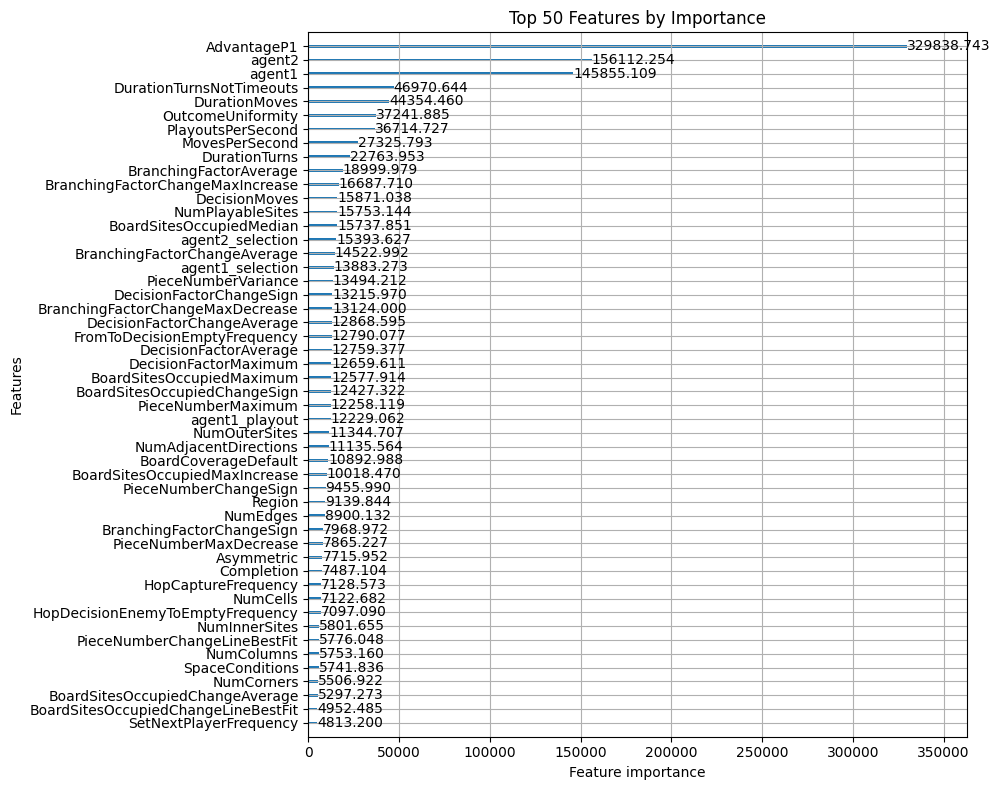

Fold 1 - RMSE: 0.4119583311694957
Fold 2


[100]	valid_0's rmse: 0.456291


[200]	valid_0's rmse: 0.437087


[300]	valid_0's rmse: 0.430312


[400]	valid_0's rmse: 0.426225


[500]	valid_0's rmse: 0.42302


[600]	valid_0's rmse: 0.421008


[700]	valid_0's rmse: 0.41942


[800]	valid_0's rmse: 0.417779


[900]	valid_0's rmse: 0.416406


[1000]	valid_0's rmse: 0.415262


[1100]	valid_0's rmse: 0.414211


[1200]	valid_0's rmse: 0.413608


[1300]	valid_0's rmse: 0.412747


[1400]	valid_0's rmse: 0.412186


[1500]	valid_0's rmse: 0.411672


[1600]	valid_0's rmse: 0.411268


[1700]	valid_0's rmse: 0.410846


[1800]	valid_0's rmse: 0.410484


[1900]	valid_0's rmse: 0.410069


[2000]	valid_0's rmse: 0.409638


[2100]	valid_0's rmse: 0.40934


[2200]	valid_0's rmse: 0.40906


[2300]	valid_0's rmse: 0.408773


[2400]	valid_0's rmse: 0.408485


[2500]	valid_0's rmse: 0.408208


[2600]	valid_0's rmse: 0.408013


[2700]	valid_0's rmse: 0.407876


[2800]	valid_0's rmse: 0.40765


[2900]	valid_0's rmse: 0.407498


[3000]	valid_0's rmse: 0.407331


[3100]	valid_0's rmse: 0.407259


[3200]	valid_0's rmse: 0.407149


[3300]	valid_0's rmse: 0.40709


[3400]	valid_0's rmse: 0.407012


[3500]	valid_0's rmse: 0.406967


[3600]	valid_0's rmse: 0.406889


[3700]	valid_0's rmse: 0.406753


[3800]	valid_0's rmse: 0.406518


[3900]	valid_0's rmse: 0.406442


[4000]	valid_0's rmse: 0.406349


[4100]	valid_0's rmse: 0.406283


[4200]	valid_0's rmse: 0.40624


[4300]	valid_0's rmse: 0.406154


[4400]	valid_0's rmse: 0.405966


[4500]	valid_0's rmse: 0.405942


[4600]	valid_0's rmse: 0.405963


[4700]	valid_0's rmse: 0.405867


[4800]	valid_0's rmse: 0.405776


[4900]	valid_0's rmse: 0.405736


[5000]	valid_0's rmse: 0.405669


[5100]	valid_0's rmse: 0.405617


[5200]	valid_0's rmse: 0.405619


[5300]	valid_0's rmse: 0.405644


[5400]	valid_0's rmse: 0.40559


[5500]	valid_0's rmse: 0.405546


[5600]	valid_0's rmse: 0.405558


[5700]	valid_0's rmse: 0.405576


[5800]	valid_0's rmse: 0.405547


[5900]	valid_0's rmse: 0.405538


[6000]	valid_0's rmse: 0.405541


[6100]	valid_0's rmse: 0.405533


[6200]	valid_0's rmse: 0.405528


[6300]	valid_0's rmse: 0.405581


[6400]	valid_0's rmse: 0.405563


[6500]	valid_0's rmse: 0.405605


[6600]	valid_0's rmse: 0.405583


[6700]	valid_0's rmse: 0.405549


[6800]	valid_0's rmse: 0.405575


[6900]	valid_0's rmse: 0.405521


[7000]	valid_0's rmse: 0.405496


[7100]	valid_0's rmse: 0.405441


[7200]	valid_0's rmse: 0.405425


[7300]	valid_0's rmse: 0.405432


[7400]	valid_0's rmse: 0.405397


[7500]	valid_0's rmse: 0.405365


[7600]	valid_0's rmse: 0.405345


[7700]	valid_0's rmse: 0.405329


[7800]	valid_0's rmse: 0.405282


[7900]	valid_0's rmse: 0.405259


[8000]	valid_0's rmse: 0.405273


[8100]	valid_0's rmse: 0.405273


[8200]	valid_0's rmse: 0.405284


[8300]	valid_0's rmse: 0.405297


[8400]	valid_0's rmse: 0.405348


[8500]	valid_0's rmse: 0.405349


[8600]	valid_0's rmse: 0.405303


[8700]	valid_0's rmse: 0.405259


[8800]	valid_0's rmse: 0.405279


[8900]	valid_0's rmse: 0.405242


[9000]	valid_0's rmse: 0.4053


[9100]	valid_0's rmse: 0.405307


[9200]	valid_0's rmse: 0.405318


[9300]	valid_0's rmse: 0.405347


[9400]	valid_0's rmse: 0.405392


[9500]	valid_0's rmse: 0.405335


[9600]	valid_0's rmse: 0.405354


[9700]	valid_0's rmse: 0.405322


[9800]	valid_0's rmse: 0.40536


[9900]	valid_0's rmse: 0.405358


[10000]	valid_0's rmse: 0.405341


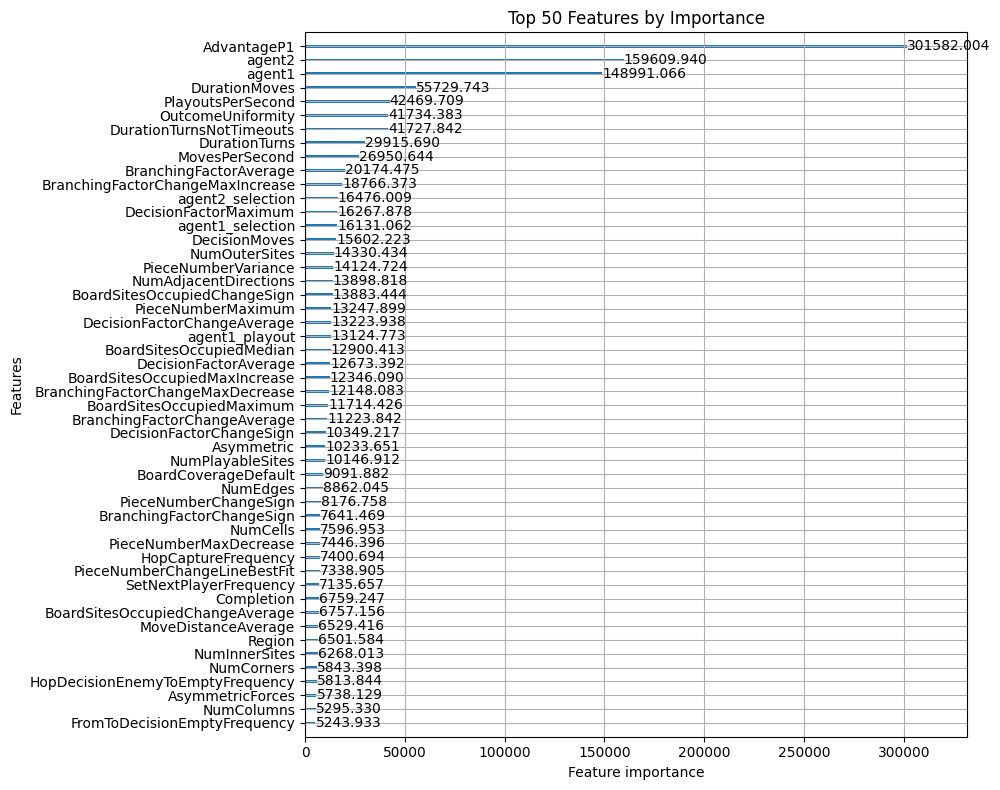

Fold 2 - RMSE: 0.40448963925913817
Fold 3


[100]	valid_0's rmse: 0.52472


[200]	valid_0's rmse: 0.495193


[300]	valid_0's rmse: 0.482129


[400]	valid_0's rmse: 0.472636


[500]	valid_0's rmse: 0.466619


[600]	valid_0's rmse: 0.461795


[700]	valid_0's rmse: 0.457756


[800]	valid_0's rmse: 0.454998


[900]	valid_0's rmse: 0.452221


[1000]	valid_0's rmse: 0.449899


[1100]	valid_0's rmse: 0.448318


[1200]	valid_0's rmse: 0.446619


[1300]	valid_0's rmse: 0.445141


[1400]	valid_0's rmse: 0.443947


[1500]	valid_0's rmse: 0.442678


[1600]	valid_0's rmse: 0.441785


[1700]	valid_0's rmse: 0.440954


[1800]	valid_0's rmse: 0.440263


[1900]	valid_0's rmse: 0.439471


[2000]	valid_0's rmse: 0.438835


[2100]	valid_0's rmse: 0.438341


[2200]	valid_0's rmse: 0.437791


[2300]	valid_0's rmse: 0.437234


[2400]	valid_0's rmse: 0.436803


[2500]	valid_0's rmse: 0.43654


[2600]	valid_0's rmse: 0.435996


[2700]	valid_0's rmse: 0.435614


[2800]	valid_0's rmse: 0.435268


[2900]	valid_0's rmse: 0.434771


[3000]	valid_0's rmse: 0.434448


[3100]	valid_0's rmse: 0.434099


[3200]	valid_0's rmse: 0.433798


[3300]	valid_0's rmse: 0.433609


[3400]	valid_0's rmse: 0.433349


[3500]	valid_0's rmse: 0.433106


[3600]	valid_0's rmse: 0.432824


[3700]	valid_0's rmse: 0.432623


[3800]	valid_0's rmse: 0.432393


[3900]	valid_0's rmse: 0.432171


[4000]	valid_0's rmse: 0.43189


[4100]	valid_0's rmse: 0.431704


[4200]	valid_0's rmse: 0.431582


[4300]	valid_0's rmse: 0.431516


[4400]	valid_0's rmse: 0.431404


[4500]	valid_0's rmse: 0.431284


[4600]	valid_0's rmse: 0.431134


[4700]	valid_0's rmse: 0.431009


[4800]	valid_0's rmse: 0.430804


[4900]	valid_0's rmse: 0.430666


[5000]	valid_0's rmse: 0.430637


[5100]	valid_0's rmse: 0.430513


[5200]	valid_0's rmse: 0.430431


[5300]	valid_0's rmse: 0.430377


[5400]	valid_0's rmse: 0.430253


[5500]	valid_0's rmse: 0.430147


[5600]	valid_0's rmse: 0.430047


[5700]	valid_0's rmse: 0.429947


[5800]	valid_0's rmse: 0.429919


[5900]	valid_0's rmse: 0.42984


[6000]	valid_0's rmse: 0.429722


[6100]	valid_0's rmse: 0.429613


[6200]	valid_0's rmse: 0.429538


[6300]	valid_0's rmse: 0.429463


[6400]	valid_0's rmse: 0.429356


[6500]	valid_0's rmse: 0.42933


[6600]	valid_0's rmse: 0.429257


[6700]	valid_0's rmse: 0.429151


[6800]	valid_0's rmse: 0.42906


[6900]	valid_0's rmse: 0.429013


[7000]	valid_0's rmse: 0.428883


[7100]	valid_0's rmse: 0.428831


[7200]	valid_0's rmse: 0.428717


[7300]	valid_0's rmse: 0.428682


[7400]	valid_0's rmse: 0.428639


[7500]	valid_0's rmse: 0.428597


[7600]	valid_0's rmse: 0.428552


[7700]	valid_0's rmse: 0.428496


[7800]	valid_0's rmse: 0.428467


[7900]	valid_0's rmse: 0.428438


[8000]	valid_0's rmse: 0.4284


[8100]	valid_0's rmse: 0.428339


[8200]	valid_0's rmse: 0.428269


[8300]	valid_0's rmse: 0.428235


[8400]	valid_0's rmse: 0.428194


[8500]	valid_0's rmse: 0.428122


[8600]	valid_0's rmse: 0.428114


[8700]	valid_0's rmse: 0.428078


[8800]	valid_0's rmse: 0.42801


[8900]	valid_0's rmse: 0.428012


[9000]	valid_0's rmse: 0.427969


[9100]	valid_0's rmse: 0.427909


[9200]	valid_0's rmse: 0.427882


[9300]	valid_0's rmse: 0.4279


[9400]	valid_0's rmse: 0.427863


[9500]	valid_0's rmse: 0.427862


[9600]	valid_0's rmse: 0.427827


[9700]	valid_0's rmse: 0.427773


[9800]	valid_0's rmse: 0.427744


[9900]	valid_0's rmse: 0.427666


[10000]	valid_0's rmse: 0.427632


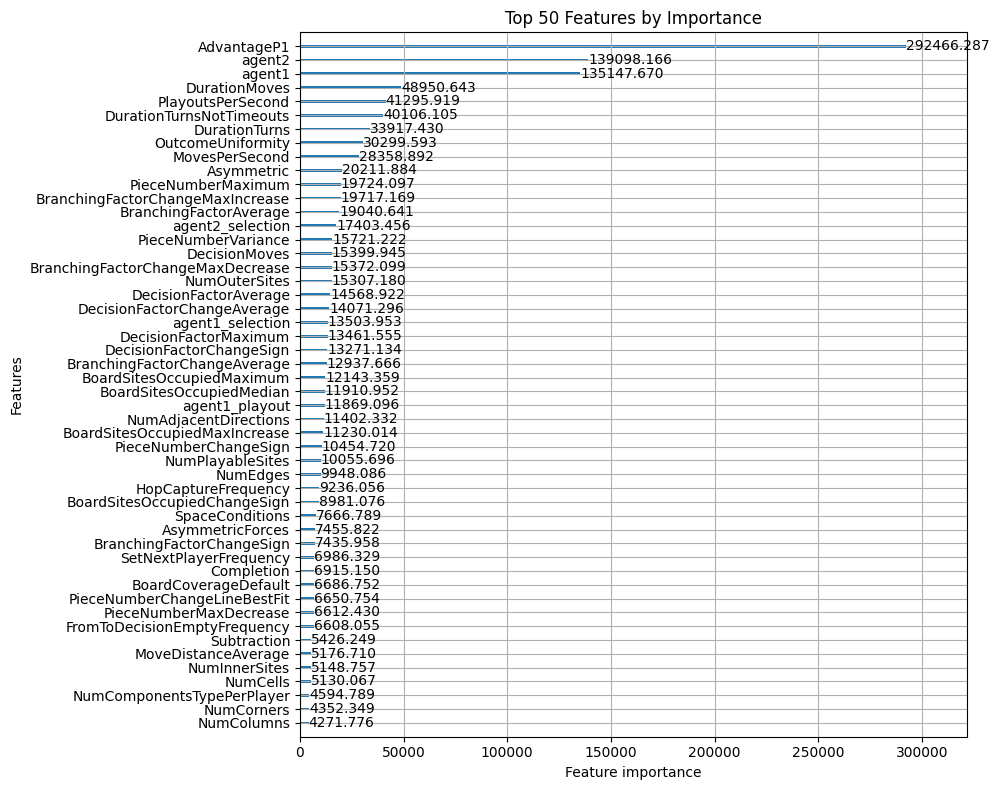

Fold 3 - RMSE: 0.4269350819336456
Fold 4


[100]	valid_0's rmse: 0.52037


[200]	valid_0's rmse: 0.494986


[300]	valid_0's rmse: 0.484772


[400]	valid_0's rmse: 0.476108


[500]	valid_0's rmse: 0.46969


[600]	valid_0's rmse: 0.466052


[700]	valid_0's rmse: 0.46277


[800]	valid_0's rmse: 0.460454


[900]	valid_0's rmse: 0.458438


[1000]	valid_0's rmse: 0.456557


[1100]	valid_0's rmse: 0.455487


[1200]	valid_0's rmse: 0.454031


[1300]	valid_0's rmse: 0.45298


[1400]	valid_0's rmse: 0.45208


[1500]	valid_0's rmse: 0.451356


[1600]	valid_0's rmse: 0.450575


[1700]	valid_0's rmse: 0.449808


[1800]	valid_0's rmse: 0.449137


[1900]	valid_0's rmse: 0.448711


[2000]	valid_0's rmse: 0.448225


[2100]	valid_0's rmse: 0.447759


[2200]	valid_0's rmse: 0.44729


[2300]	valid_0's rmse: 0.446881


[2400]	valid_0's rmse: 0.446458


[2500]	valid_0's rmse: 0.446073


[2600]	valid_0's rmse: 0.445815


[2700]	valid_0's rmse: 0.445554


[2800]	valid_0's rmse: 0.445356


[2900]	valid_0's rmse: 0.445013


[3000]	valid_0's rmse: 0.444685


[3100]	valid_0's rmse: 0.444511


[3200]	valid_0's rmse: 0.444207


[3300]	valid_0's rmse: 0.443946


[3400]	valid_0's rmse: 0.443765


[3500]	valid_0's rmse: 0.443487


[3600]	valid_0's rmse: 0.443355


[3700]	valid_0's rmse: 0.443184


[3800]	valid_0's rmse: 0.443061


[3900]	valid_0's rmse: 0.442908


[4000]	valid_0's rmse: 0.442665


[4100]	valid_0's rmse: 0.442623


[4200]	valid_0's rmse: 0.442495


[4300]	valid_0's rmse: 0.442406


[4400]	valid_0's rmse: 0.442318


[4500]	valid_0's rmse: 0.442217


[4600]	valid_0's rmse: 0.442104


[4700]	valid_0's rmse: 0.442021


[4800]	valid_0's rmse: 0.441903


[4900]	valid_0's rmse: 0.44181


[5000]	valid_0's rmse: 0.441727


[5100]	valid_0's rmse: 0.441658


[5200]	valid_0's rmse: 0.441613


[5300]	valid_0's rmse: 0.4415


[5400]	valid_0's rmse: 0.441426


[5500]	valid_0's rmse: 0.441353


[5600]	valid_0's rmse: 0.441256


[5700]	valid_0's rmse: 0.441216


[5800]	valid_0's rmse: 0.441269


[5900]	valid_0's rmse: 0.441138


[6000]	valid_0's rmse: 0.441006


[6100]	valid_0's rmse: 0.44101


[6200]	valid_0's rmse: 0.440943


[6300]	valid_0's rmse: 0.440911


[6400]	valid_0's rmse: 0.440906


[6500]	valid_0's rmse: 0.440861


[6600]	valid_0's rmse: 0.440834


[6700]	valid_0's rmse: 0.440768


[6800]	valid_0's rmse: 0.440695


[6900]	valid_0's rmse: 0.44069


[7000]	valid_0's rmse: 0.440598


[7100]	valid_0's rmse: 0.440563


[7200]	valid_0's rmse: 0.440519


[7300]	valid_0's rmse: 0.440529


[7400]	valid_0's rmse: 0.44043


[7500]	valid_0's rmse: 0.440434


[7600]	valid_0's rmse: 0.440382


[7700]	valid_0's rmse: 0.440379


[7800]	valid_0's rmse: 0.440308


[7900]	valid_0's rmse: 0.440355


[8000]	valid_0's rmse: 0.440289


[8100]	valid_0's rmse: 0.440243


[8200]	valid_0's rmse: 0.440245


[8300]	valid_0's rmse: 0.440183


[8400]	valid_0's rmse: 0.440249


[8500]	valid_0's rmse: 0.440164


[8600]	valid_0's rmse: 0.440149


[8700]	valid_0's rmse: 0.440094


[8800]	valid_0's rmse: 0.44007


[8900]	valid_0's rmse: 0.440019


[9000]	valid_0's rmse: 0.440051


[9100]	valid_0's rmse: 0.440071


[9200]	valid_0's rmse: 0.440064


[9300]	valid_0's rmse: 0.440084


[9400]	valid_0's rmse: 0.44005


[9500]	valid_0's rmse: 0.440053


[9600]	valid_0's rmse: 0.440074


[9700]	valid_0's rmse: 0.44011


[9800]	valid_0's rmse: 0.440041


[9900]	valid_0's rmse: 0.439983


[10000]	valid_0's rmse: 0.439938


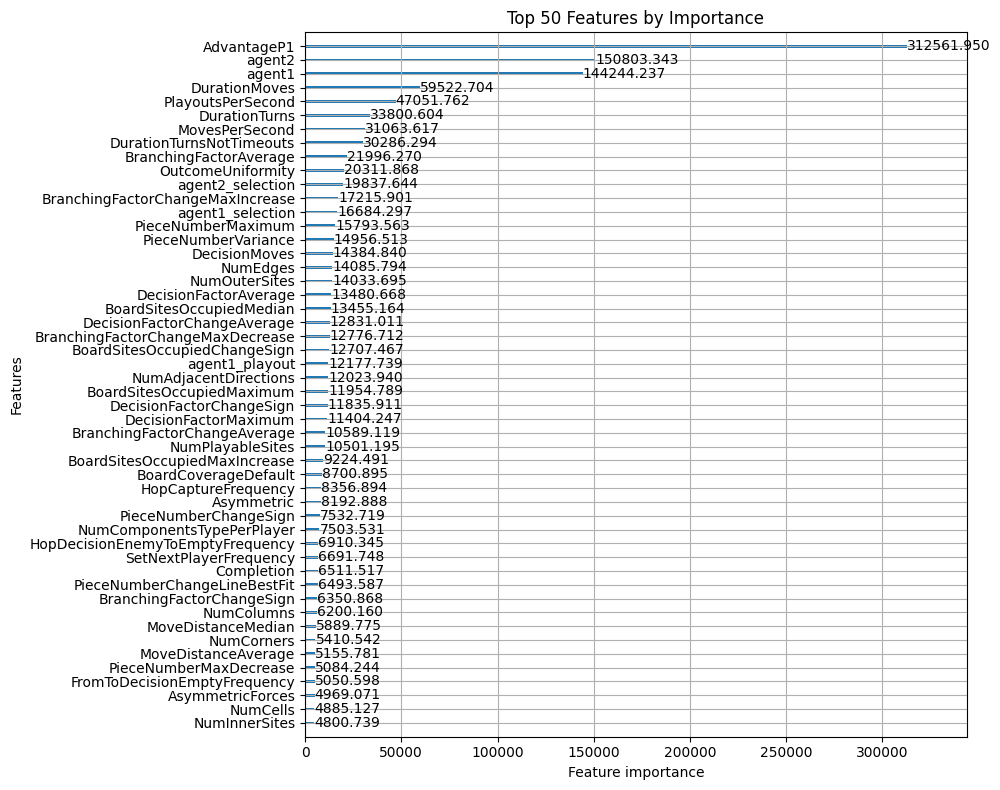

Fold 4 - RMSE: 0.4394710413142403
Fold 5


[100]	valid_0's rmse: 0.515355


[200]	valid_0's rmse: 0.489624


[300]	valid_0's rmse: 0.475971


[400]	valid_0's rmse: 0.466927


[500]	valid_0's rmse: 0.461886


[600]	valid_0's rmse: 0.457758


[700]	valid_0's rmse: 0.453862


[800]	valid_0's rmse: 0.450796


[900]	valid_0's rmse: 0.448339


[1000]	valid_0's rmse: 0.44588


[1100]	valid_0's rmse: 0.444137


[1200]	valid_0's rmse: 0.442575


[1300]	valid_0's rmse: 0.441065


[1400]	valid_0's rmse: 0.439964


[1500]	valid_0's rmse: 0.438699


[1600]	valid_0's rmse: 0.437945


[1700]	valid_0's rmse: 0.436971


[1800]	valid_0's rmse: 0.436316


[1900]	valid_0's rmse: 0.435621


[2000]	valid_0's rmse: 0.435048


[2100]	valid_0's rmse: 0.434483


[2200]	valid_0's rmse: 0.433882


[2300]	valid_0's rmse: 0.433436


[2400]	valid_0's rmse: 0.433052


[2500]	valid_0's rmse: 0.432633


[2600]	valid_0's rmse: 0.432324


[2700]	valid_0's rmse: 0.431933


[2800]	valid_0's rmse: 0.431513


[2900]	valid_0's rmse: 0.431154


[3000]	valid_0's rmse: 0.430813


[3100]	valid_0's rmse: 0.430499


[3200]	valid_0's rmse: 0.43015


[3300]	valid_0's rmse: 0.429859


[3400]	valid_0's rmse: 0.429811


[3500]	valid_0's rmse: 0.429636


[3600]	valid_0's rmse: 0.429405


[3700]	valid_0's rmse: 0.429203


[3800]	valid_0's rmse: 0.428998


[3900]	valid_0's rmse: 0.428875


[4000]	valid_0's rmse: 0.428744


[4100]	valid_0's rmse: 0.428615


[4200]	valid_0's rmse: 0.428465


[4300]	valid_0's rmse: 0.428419


[4400]	valid_0's rmse: 0.428262


[4500]	valid_0's rmse: 0.428085


[4600]	valid_0's rmse: 0.42802


[4700]	valid_0's rmse: 0.427902


[4800]	valid_0's rmse: 0.427778


[4900]	valid_0's rmse: 0.427644


[5000]	valid_0's rmse: 0.427539


[5100]	valid_0's rmse: 0.427403


[5200]	valid_0's rmse: 0.427325


[5300]	valid_0's rmse: 0.427231


[5400]	valid_0's rmse: 0.42718


[5500]	valid_0's rmse: 0.427057


[5600]	valid_0's rmse: 0.42701


[5700]	valid_0's rmse: 0.426976


[5800]	valid_0's rmse: 0.426912


[5900]	valid_0's rmse: 0.426834


[6000]	valid_0's rmse: 0.42677


[6100]	valid_0's rmse: 0.426701


[6200]	valid_0's rmse: 0.426617


[6300]	valid_0's rmse: 0.426506


[6400]	valid_0's rmse: 0.426465


[6500]	valid_0's rmse: 0.426424


[6600]	valid_0's rmse: 0.426347


[6700]	valid_0's rmse: 0.426286


[6800]	valid_0's rmse: 0.426211


[6900]	valid_0's rmse: 0.426176


[7000]	valid_0's rmse: 0.4261


[7100]	valid_0's rmse: 0.426135


[7200]	valid_0's rmse: 0.426142


[7300]	valid_0's rmse: 0.42613


[7400]	valid_0's rmse: 0.426054


[7500]	valid_0's rmse: 0.426013


[7600]	valid_0's rmse: 0.425953


[7700]	valid_0's rmse: 0.425925


[7800]	valid_0's rmse: 0.425922


[7900]	valid_0's rmse: 0.42588


[8000]	valid_0's rmse: 0.425817


[8100]	valid_0's rmse: 0.425849


[8200]	valid_0's rmse: 0.425758


[8300]	valid_0's rmse: 0.425774


[8400]	valid_0's rmse: 0.42576


[8500]	valid_0's rmse: 0.425699


[8600]	valid_0's rmse: 0.425672


[8700]	valid_0's rmse: 0.425622


[8800]	valid_0's rmse: 0.425608


[8900]	valid_0's rmse: 0.425569


[9000]	valid_0's rmse: 0.425544


[9100]	valid_0's rmse: 0.425437


[9200]	valid_0's rmse: 0.425351


[9300]	valid_0's rmse: 0.425335


[9400]	valid_0's rmse: 0.425308


[9500]	valid_0's rmse: 0.425267


[9600]	valid_0's rmse: 0.425242


[9700]	valid_0's rmse: 0.425195


[9800]	valid_0's rmse: 0.425196


[9900]	valid_0's rmse: 0.425224


[10000]	valid_0's rmse: 0.425259


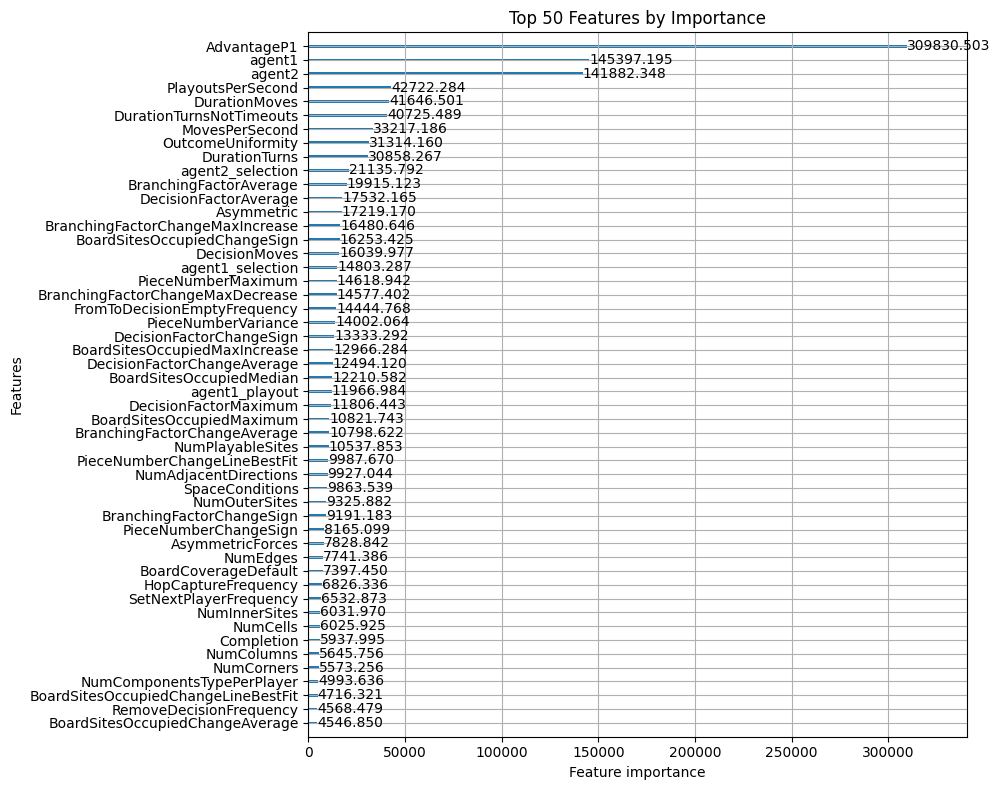

Fold 5 - RMSE: 0.42468102741018016
List of oof scores: [0.4119583311694957, 0.40448963925913817, 0.4269350819336456, 0.4394710413142403, 0.42468102741018016]
Average oof score: 0.42150702421733993


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.503463


[200]	valid_0's rmse: 0.477815


[300]	valid_0's rmse: 0.466904


[400]	valid_0's rmse: 0.460097


[500]	valid_0's rmse: 0.455622


[600]	valid_0's rmse: 0.452647


[700]	valid_0's rmse: 0.450015


[800]	valid_0's rmse: 0.448028


[900]	valid_0's rmse: 0.446325


[1000]	valid_0's rmse: 0.444461


[1100]	valid_0's rmse: 0.443285


[1200]	valid_0's rmse: 0.442088


[1300]	valid_0's rmse: 0.441135


[1400]	valid_0's rmse: 0.440339


[1500]	valid_0's rmse: 0.439589


[1600]	valid_0's rmse: 0.438906


[1700]	valid_0's rmse: 0.43814


[1800]	valid_0's rmse: 0.437792


[1900]	valid_0's rmse: 0.437091


[2000]	valid_0's rmse: 0.436682


[2100]	valid_0's rmse: 0.4364


[2200]	valid_0's rmse: 0.436025


[2300]	valid_0's rmse: 0.435627


[2400]	valid_0's rmse: 0.435276


[2500]	valid_0's rmse: 0.435002


[2600]	valid_0's rmse: 0.434652


[2700]	valid_0's rmse: 0.434286


[2800]	valid_0's rmse: 0.434017


[2900]	valid_0's rmse: 0.433754


[3000]	valid_0's rmse: 0.43348


[3100]	valid_0's rmse: 0.433216


[3200]	valid_0's rmse: 0.432986


[3300]	valid_0's rmse: 0.432832


[3400]	valid_0's rmse: 0.432623


[3500]	valid_0's rmse: 0.432386


[3600]	valid_0's rmse: 0.432262


[3700]	valid_0's rmse: 0.432139


[3800]	valid_0's rmse: 0.431891


[3900]	valid_0's rmse: 0.431845


[4000]	valid_0's rmse: 0.431673


[4100]	valid_0's rmse: 0.431554


[4200]	valid_0's rmse: 0.431312


[4300]	valid_0's rmse: 0.431172


[4400]	valid_0's rmse: 0.431002


[4500]	valid_0's rmse: 0.430893


[4600]	valid_0's rmse: 0.430833


[4700]	valid_0's rmse: 0.430685


[4800]	valid_0's rmse: 0.430529


[4900]	valid_0's rmse: 0.430463


[5000]	valid_0's rmse: 0.430396


[5100]	valid_0's rmse: 0.430258


[5200]	valid_0's rmse: 0.430171


[5300]	valid_0's rmse: 0.430114


[5400]	valid_0's rmse: 0.430068


[5500]	valid_0's rmse: 0.429984


[5600]	valid_0's rmse: 0.429961


[5700]	valid_0's rmse: 0.429847


[5800]	valid_0's rmse: 0.429791


[5900]	valid_0's rmse: 0.429791


[6000]	valid_0's rmse: 0.429727


[6100]	valid_0's rmse: 0.429717


[6200]	valid_0's rmse: 0.429718


[6300]	valid_0's rmse: 0.42964


[6400]	valid_0's rmse: 0.429599


[6500]	valid_0's rmse: 0.429513


[6600]	valid_0's rmse: 0.429455


[6700]	valid_0's rmse: 0.429406


[6800]	valid_0's rmse: 0.429312


[6900]	valid_0's rmse: 0.429275


[7000]	valid_0's rmse: 0.429218


[7100]	valid_0's rmse: 0.429209


[7200]	valid_0's rmse: 0.429185


[7300]	valid_0's rmse: 0.429136


[7400]	valid_0's rmse: 0.429142


[7500]	valid_0's rmse: 0.429031


[7600]	valid_0's rmse: 0.429009


[7700]	valid_0's rmse: 0.429014


[7800]	valid_0's rmse: 0.429036


[7900]	valid_0's rmse: 0.429023


[8000]	valid_0's rmse: 0.42901


[8100]	valid_0's rmse: 0.428951


[8200]	valid_0's rmse: 0.428928


[8300]	valid_0's rmse: 0.428914


[8400]	valid_0's rmse: 0.42891


[8500]	valid_0's rmse: 0.428868


[8600]	valid_0's rmse: 0.428887


[8700]	valid_0's rmse: 0.428945


[8800]	valid_0's rmse: 0.428911


[8900]	valid_0's rmse: 0.428884


[9000]	valid_0's rmse: 0.428844


[9100]	valid_0's rmse: 0.42885


[9200]	valid_0's rmse: 0.428772


[9300]	valid_0's rmse: 0.428747


[9400]	valid_0's rmse: 0.428686


[9500]	valid_0's rmse: 0.428657


[9600]	valid_0's rmse: 0.428661


[9700]	valid_0's rmse: 0.428666


[9800]	valid_0's rmse: 0.428659


[9900]	valid_0's rmse: 0.428638


[10000]	valid_0's rmse: 0.42863


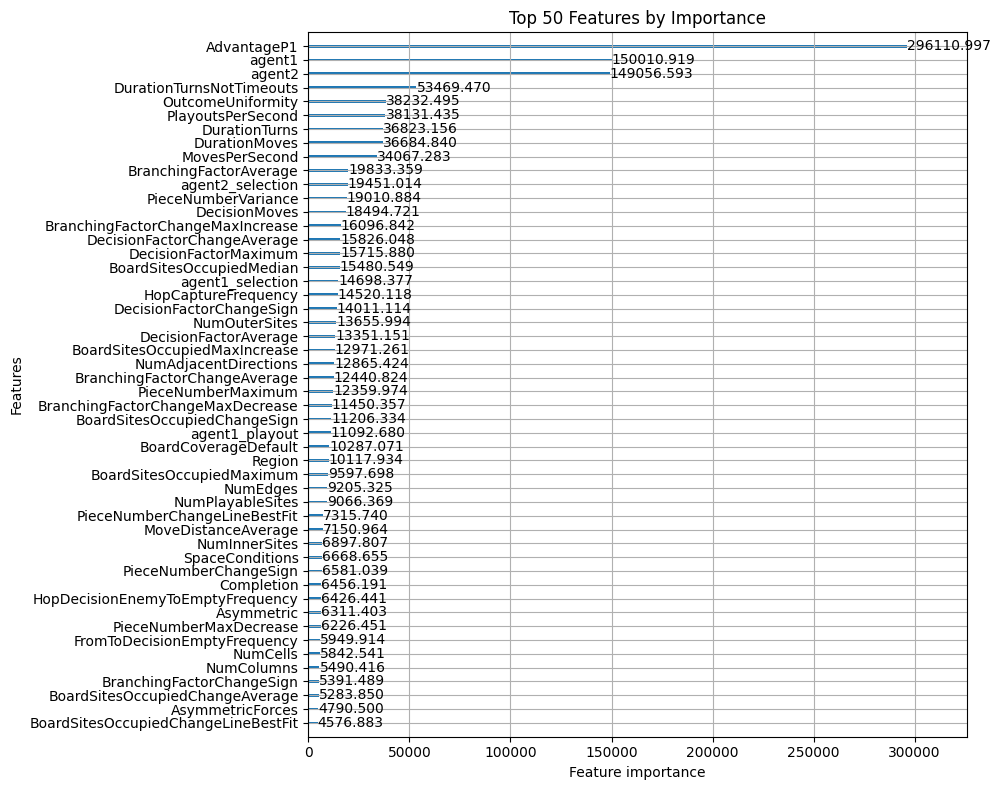

Fold 1 - RMSE: 0.42815572462710627
Fold 2


[100]	valid_0's rmse: 0.510165


[200]	valid_0's rmse: 0.486227


[300]	valid_0's rmse: 0.473852


[400]	valid_0's rmse: 0.465797


[500]	valid_0's rmse: 0.460268


[600]	valid_0's rmse: 0.455019


[700]	valid_0's rmse: 0.451407


[800]	valid_0's rmse: 0.448121


[900]	valid_0's rmse: 0.445172


[1000]	valid_0's rmse: 0.44259


[1100]	valid_0's rmse: 0.440736


[1200]	valid_0's rmse: 0.439082


[1300]	valid_0's rmse: 0.43763


[1400]	valid_0's rmse: 0.436185


[1500]	valid_0's rmse: 0.435124


[1600]	valid_0's rmse: 0.43408


[1700]	valid_0's rmse: 0.433175


[1800]	valid_0's rmse: 0.432427


[1900]	valid_0's rmse: 0.431774


[2000]	valid_0's rmse: 0.430977


[2100]	valid_0's rmse: 0.430479


[2200]	valid_0's rmse: 0.429796


[2300]	valid_0's rmse: 0.429171


[2400]	valid_0's rmse: 0.428709


[2500]	valid_0's rmse: 0.428271


[2600]	valid_0's rmse: 0.427832


[2700]	valid_0's rmse: 0.427321


[2800]	valid_0's rmse: 0.42702


[2900]	valid_0's rmse: 0.426541


[3000]	valid_0's rmse: 0.426205


[3100]	valid_0's rmse: 0.425799


[3200]	valid_0's rmse: 0.425369


[3300]	valid_0's rmse: 0.425048


[3400]	valid_0's rmse: 0.424668


[3500]	valid_0's rmse: 0.424371


[3600]	valid_0's rmse: 0.424022


[3700]	valid_0's rmse: 0.423749


[3800]	valid_0's rmse: 0.423528


[3900]	valid_0's rmse: 0.42334


[4000]	valid_0's rmse: 0.423084


[4100]	valid_0's rmse: 0.422982


[4200]	valid_0's rmse: 0.422819


[4300]	valid_0's rmse: 0.422562


[4400]	valid_0's rmse: 0.422508


[4500]	valid_0's rmse: 0.422363


[4600]	valid_0's rmse: 0.422152


[4700]	valid_0's rmse: 0.422001


[4800]	valid_0's rmse: 0.421879


[4900]	valid_0's rmse: 0.421743


[5000]	valid_0's rmse: 0.42161


[5100]	valid_0's rmse: 0.421421


[5200]	valid_0's rmse: 0.421315


[5300]	valid_0's rmse: 0.421135


[5400]	valid_0's rmse: 0.421016


[5500]	valid_0's rmse: 0.420854


[5600]	valid_0's rmse: 0.420737


[5700]	valid_0's rmse: 0.420677


[5800]	valid_0's rmse: 0.420541


[5900]	valid_0's rmse: 0.420396


[6000]	valid_0's rmse: 0.420274


[6100]	valid_0's rmse: 0.420201


[6200]	valid_0's rmse: 0.420068


[6300]	valid_0's rmse: 0.420014


[6400]	valid_0's rmse: 0.419889


[6500]	valid_0's rmse: 0.419806


[6600]	valid_0's rmse: 0.419729


[6700]	valid_0's rmse: 0.419671


[6800]	valid_0's rmse: 0.419629


[6900]	valid_0's rmse: 0.419541


[7000]	valid_0's rmse: 0.419509


[7100]	valid_0's rmse: 0.419454


[7200]	valid_0's rmse: 0.4194


[7300]	valid_0's rmse: 0.419359


[7400]	valid_0's rmse: 0.419328


[7500]	valid_0's rmse: 0.419209


[7600]	valid_0's rmse: 0.419155


[7700]	valid_0's rmse: 0.419121


[7800]	valid_0's rmse: 0.419039


[7900]	valid_0's rmse: 0.418945


[8000]	valid_0's rmse: 0.418881


[8100]	valid_0's rmse: 0.418819


[8200]	valid_0's rmse: 0.418749


[8300]	valid_0's rmse: 0.418706


[8400]	valid_0's rmse: 0.418685


[8500]	valid_0's rmse: 0.418639


[8600]	valid_0's rmse: 0.418575


[8700]	valid_0's rmse: 0.418528


[8800]	valid_0's rmse: 0.418503


[8900]	valid_0's rmse: 0.418442


[9000]	valid_0's rmse: 0.418396


[9100]	valid_0's rmse: 0.41837


[9200]	valid_0's rmse: 0.41832


[9300]	valid_0's rmse: 0.418207


[9400]	valid_0's rmse: 0.418137


[9500]	valid_0's rmse: 0.418102


[9600]	valid_0's rmse: 0.41806


[9700]	valid_0's rmse: 0.418042


[9800]	valid_0's rmse: 0.41804


[9900]	valid_0's rmse: 0.418022


[10000]	valid_0's rmse: 0.418032


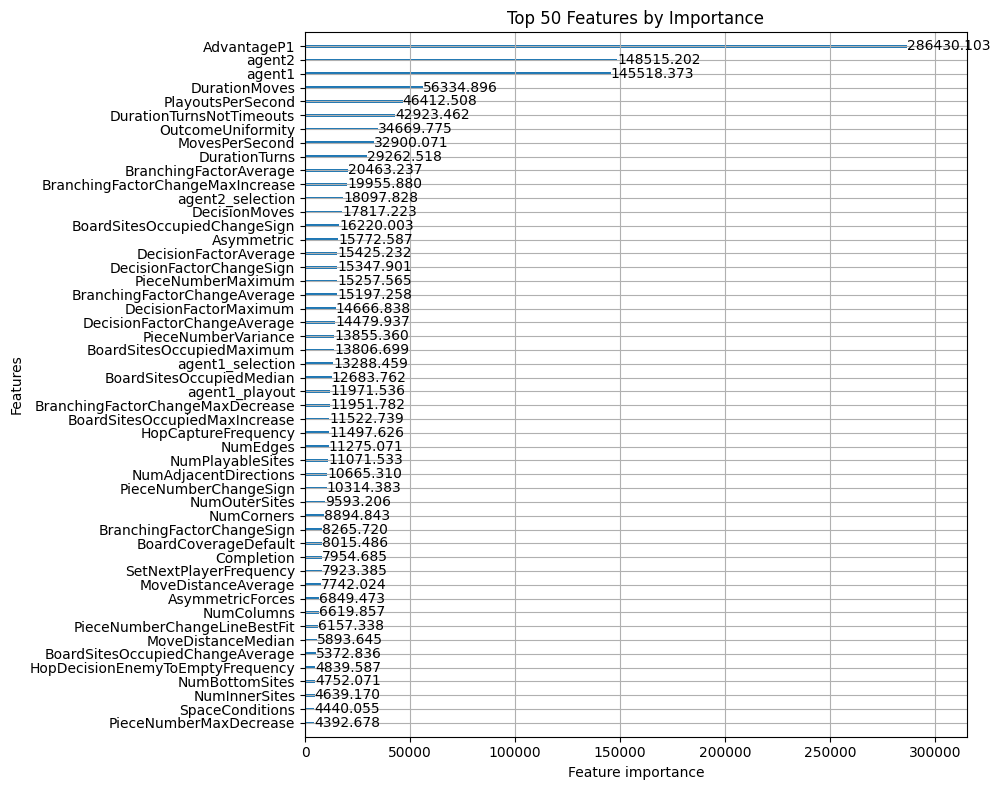

Fold 2 - RMSE: 0.4175825446623493
Fold 3


[100]	valid_0's rmse: 0.49698


[200]	valid_0's rmse: 0.474775


[300]	valid_0's rmse: 0.464415


[400]	valid_0's rmse: 0.457859


[500]	valid_0's rmse: 0.453082


[600]	valid_0's rmse: 0.450104


[700]	valid_0's rmse: 0.447338


[800]	valid_0's rmse: 0.445367


[900]	valid_0's rmse: 0.443628


[1000]	valid_0's rmse: 0.442062


[1100]	valid_0's rmse: 0.440475


[1200]	valid_0's rmse: 0.439382


[1300]	valid_0's rmse: 0.438547


[1400]	valid_0's rmse: 0.437667


[1500]	valid_0's rmse: 0.436838


[1600]	valid_0's rmse: 0.436042


[1700]	valid_0's rmse: 0.435377


[1800]	valid_0's rmse: 0.434908


[1900]	valid_0's rmse: 0.434412


[2000]	valid_0's rmse: 0.433993


[2100]	valid_0's rmse: 0.433628


[2200]	valid_0's rmse: 0.433256


[2300]	valid_0's rmse: 0.432831


[2400]	valid_0's rmse: 0.432728


[2500]	valid_0's rmse: 0.432286


[2600]	valid_0's rmse: 0.431908


[2700]	valid_0's rmse: 0.431616


[2800]	valid_0's rmse: 0.431436


[2900]	valid_0's rmse: 0.431121


[3000]	valid_0's rmse: 0.430849


[3100]	valid_0's rmse: 0.430659


[3200]	valid_0's rmse: 0.430443


[3300]	valid_0's rmse: 0.430244


[3400]	valid_0's rmse: 0.430086


[3500]	valid_0's rmse: 0.429796


[3600]	valid_0's rmse: 0.429721


[3700]	valid_0's rmse: 0.429467


[3800]	valid_0's rmse: 0.429324


[3900]	valid_0's rmse: 0.429185


[4000]	valid_0's rmse: 0.429002


[4100]	valid_0's rmse: 0.428898


[4200]	valid_0's rmse: 0.428773


[4300]	valid_0's rmse: 0.428741


[4400]	valid_0's rmse: 0.428566


[4500]	valid_0's rmse: 0.428486


[4600]	valid_0's rmse: 0.428476


[4700]	valid_0's rmse: 0.428325


[4800]	valid_0's rmse: 0.428238


[4900]	valid_0's rmse: 0.428092


[5000]	valid_0's rmse: 0.428018


[5100]	valid_0's rmse: 0.427922


[5200]	valid_0's rmse: 0.427828


[5300]	valid_0's rmse: 0.427718


[5400]	valid_0's rmse: 0.427602


[5500]	valid_0's rmse: 0.427583


[5600]	valid_0's rmse: 0.427528


[5700]	valid_0's rmse: 0.427427


[5800]	valid_0's rmse: 0.42738


[5900]	valid_0's rmse: 0.427328


[6000]	valid_0's rmse: 0.427268


[6100]	valid_0's rmse: 0.427284


[6200]	valid_0's rmse: 0.427209


[6300]	valid_0's rmse: 0.427114


[6400]	valid_0's rmse: 0.427097


[6500]	valid_0's rmse: 0.427053


[6600]	valid_0's rmse: 0.427053


[6700]	valid_0's rmse: 0.427013


[6800]	valid_0's rmse: 0.426946


[6900]	valid_0's rmse: 0.426928


[7000]	valid_0's rmse: 0.426882


[7100]	valid_0's rmse: 0.426851


[7200]	valid_0's rmse: 0.426789


[7300]	valid_0's rmse: 0.426719


[7400]	valid_0's rmse: 0.426603


[7500]	valid_0's rmse: 0.426582


[7600]	valid_0's rmse: 0.426492


[7700]	valid_0's rmse: 0.426422


[7800]	valid_0's rmse: 0.426364


[7900]	valid_0's rmse: 0.426335


[8000]	valid_0's rmse: 0.426324


[8100]	valid_0's rmse: 0.426279


[8200]	valid_0's rmse: 0.426276


[8300]	valid_0's rmse: 0.426215


[8400]	valid_0's rmse: 0.426172


[8500]	valid_0's rmse: 0.426222


[8600]	valid_0's rmse: 0.42614


[8700]	valid_0's rmse: 0.426122


[8800]	valid_0's rmse: 0.4261


[8900]	valid_0's rmse: 0.42612


[9000]	valid_0's rmse: 0.426095


[9100]	valid_0's rmse: 0.426073


[9200]	valid_0's rmse: 0.426036


[9300]	valid_0's rmse: 0.426017


[9400]	valid_0's rmse: 0.425994


[9500]	valid_0's rmse: 0.425965


[9600]	valid_0's rmse: 0.425927


[9700]	valid_0's rmse: 0.425872


[9800]	valid_0's rmse: 0.425875


[9900]	valid_0's rmse: 0.42588


[10000]	valid_0's rmse: 0.42588


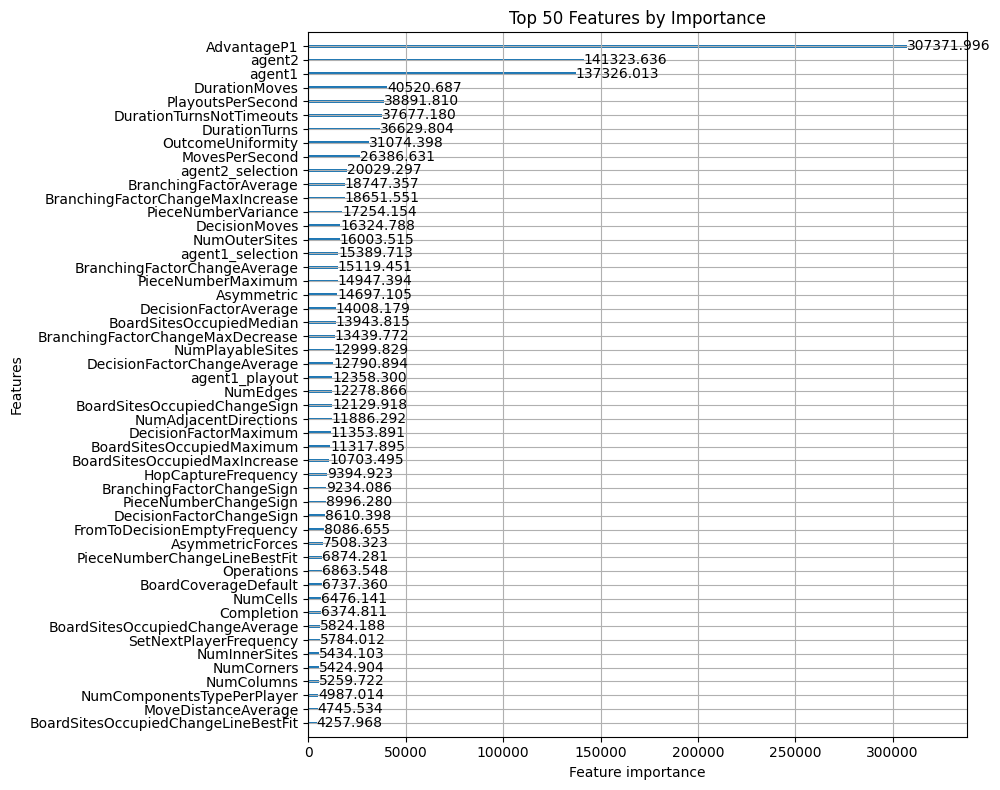

Fold 3 - RMSE: 0.4252656709917196
Fold 4


[100]	valid_0's rmse: 0.494354


[200]	valid_0's rmse: 0.469011


[300]	valid_0's rmse: 0.458022


[400]	valid_0's rmse: 0.450781


[500]	valid_0's rmse: 0.44601


[600]	valid_0's rmse: 0.441951


[700]	valid_0's rmse: 0.439123


[800]	valid_0's rmse: 0.436742


[900]	valid_0's rmse: 0.434816


[1000]	valid_0's rmse: 0.433055


[1100]	valid_0's rmse: 0.431533


[1200]	valid_0's rmse: 0.430355


[1300]	valid_0's rmse: 0.429315


[1400]	valid_0's rmse: 0.428302


[1500]	valid_0's rmse: 0.427208


[1600]	valid_0's rmse: 0.426541


[1700]	valid_0's rmse: 0.425817


[1800]	valid_0's rmse: 0.425152


[1900]	valid_0's rmse: 0.424553


[2000]	valid_0's rmse: 0.424201


[2100]	valid_0's rmse: 0.423571


[2200]	valid_0's rmse: 0.423194


[2300]	valid_0's rmse: 0.422785


[2400]	valid_0's rmse: 0.422437


[2500]	valid_0's rmse: 0.422021


[2600]	valid_0's rmse: 0.421743


[2700]	valid_0's rmse: 0.421556


[2800]	valid_0's rmse: 0.421288


[2900]	valid_0's rmse: 0.420977


[3000]	valid_0's rmse: 0.420692


[3100]	valid_0's rmse: 0.420502


[3200]	valid_0's rmse: 0.420359


[3300]	valid_0's rmse: 0.420183


[3400]	valid_0's rmse: 0.420017


[3500]	valid_0's rmse: 0.419879


[3600]	valid_0's rmse: 0.419717


[3700]	valid_0's rmse: 0.419551


[3800]	valid_0's rmse: 0.419416


[3900]	valid_0's rmse: 0.419324


[4000]	valid_0's rmse: 0.41918


[4100]	valid_0's rmse: 0.419115


[4200]	valid_0's rmse: 0.419015


[4300]	valid_0's rmse: 0.418806


[4400]	valid_0's rmse: 0.418807


[4500]	valid_0's rmse: 0.418744


[4600]	valid_0's rmse: 0.418642


[4700]	valid_0's rmse: 0.418529


[4800]	valid_0's rmse: 0.418508


[4900]	valid_0's rmse: 0.418446


[5000]	valid_0's rmse: 0.418408


[5100]	valid_0's rmse: 0.418338


[5200]	valid_0's rmse: 0.418237


[5300]	valid_0's rmse: 0.418175


[5400]	valid_0's rmse: 0.418078


[5500]	valid_0's rmse: 0.418012


[5600]	valid_0's rmse: 0.417903


[5700]	valid_0's rmse: 0.41787


[5800]	valid_0's rmse: 0.41779


[5900]	valid_0's rmse: 0.417707


[6000]	valid_0's rmse: 0.417658


[6100]	valid_0's rmse: 0.417606


[6200]	valid_0's rmse: 0.417508


[6300]	valid_0's rmse: 0.417445


[6400]	valid_0's rmse: 0.417411


[6500]	valid_0's rmse: 0.417435


[6600]	valid_0's rmse: 0.4174


[6700]	valid_0's rmse: 0.41736


[6800]	valid_0's rmse: 0.417305


[6900]	valid_0's rmse: 0.41725


[7000]	valid_0's rmse: 0.417198


[7100]	valid_0's rmse: 0.417095


[7200]	valid_0's rmse: 0.417041


[7300]	valid_0's rmse: 0.417002


[7400]	valid_0's rmse: 0.416987


[7500]	valid_0's rmse: 0.416941


[7600]	valid_0's rmse: 0.416906


[7700]	valid_0's rmse: 0.416857


[7800]	valid_0's rmse: 0.41685


[7900]	valid_0's rmse: 0.416881


[8000]	valid_0's rmse: 0.416799


[8100]	valid_0's rmse: 0.416815


[8200]	valid_0's rmse: 0.416762


[8300]	valid_0's rmse: 0.416696


[8400]	valid_0's rmse: 0.416679


[8500]	valid_0's rmse: 0.416673


[8600]	valid_0's rmse: 0.416652


[8700]	valid_0's rmse: 0.416647


[8800]	valid_0's rmse: 0.416617


[8900]	valid_0's rmse: 0.416499


[9000]	valid_0's rmse: 0.416501


[9100]	valid_0's rmse: 0.416467


[9200]	valid_0's rmse: 0.41646


[9300]	valid_0's rmse: 0.416451


[9400]	valid_0's rmse: 0.416474


[9500]	valid_0's rmse: 0.416407


[9600]	valid_0's rmse: 0.416371


[9700]	valid_0's rmse: 0.416338


[9800]	valid_0's rmse: 0.416317


[9900]	valid_0's rmse: 0.416331


[10000]	valid_0's rmse: 0.416263


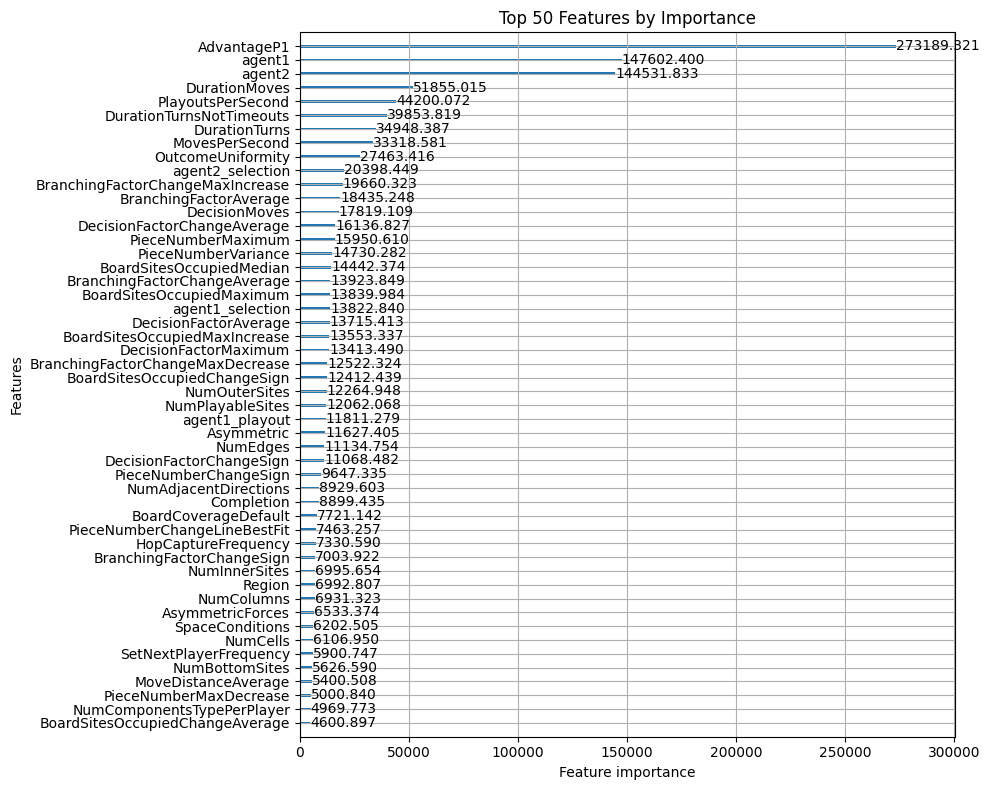

Fold 4 - RMSE: 0.4155703003377357
Fold 5


[100]	valid_0's rmse: 0.507897


[200]	valid_0's rmse: 0.482737


[300]	valid_0's rmse: 0.470367


[400]	valid_0's rmse: 0.461954


[500]	valid_0's rmse: 0.454837


[600]	valid_0's rmse: 0.450283


[700]	valid_0's rmse: 0.446357


[800]	valid_0's rmse: 0.443689


[900]	valid_0's rmse: 0.441837


[1000]	valid_0's rmse: 0.439801


[1100]	valid_0's rmse: 0.438145


[1200]	valid_0's rmse: 0.436597


[1300]	valid_0's rmse: 0.435418


[1400]	valid_0's rmse: 0.434342


[1500]	valid_0's rmse: 0.433363


[1600]	valid_0's rmse: 0.432563


[1700]	valid_0's rmse: 0.431659


[1800]	valid_0's rmse: 0.430949


[1900]	valid_0's rmse: 0.430237


[2000]	valid_0's rmse: 0.429594


[2100]	valid_0's rmse: 0.429084


[2200]	valid_0's rmse: 0.428455


[2300]	valid_0's rmse: 0.427974


[2400]	valid_0's rmse: 0.427669


[2500]	valid_0's rmse: 0.427261


[2600]	valid_0's rmse: 0.426867


[2700]	valid_0's rmse: 0.426596


[2800]	valid_0's rmse: 0.426277


[2900]	valid_0's rmse: 0.42598


[3000]	valid_0's rmse: 0.425634


[3100]	valid_0's rmse: 0.425345


[3200]	valid_0's rmse: 0.425066


[3300]	valid_0's rmse: 0.424866


[3400]	valid_0's rmse: 0.424653


[3500]	valid_0's rmse: 0.424387


[3600]	valid_0's rmse: 0.424155


[3700]	valid_0's rmse: 0.423968


[3800]	valid_0's rmse: 0.423797


[3900]	valid_0's rmse: 0.423594


[4000]	valid_0's rmse: 0.423466


[4100]	valid_0's rmse: 0.423366


[4200]	valid_0's rmse: 0.423147


[4300]	valid_0's rmse: 0.423037


[4400]	valid_0's rmse: 0.422851


[4500]	valid_0's rmse: 0.422752


[4600]	valid_0's rmse: 0.422544


[4700]	valid_0's rmse: 0.422447


[4800]	valid_0's rmse: 0.422314


[4900]	valid_0's rmse: 0.422105


[5000]	valid_0's rmse: 0.421939


[5100]	valid_0's rmse: 0.421859


[5200]	valid_0's rmse: 0.421727


[5300]	valid_0's rmse: 0.421616


[5400]	valid_0's rmse: 0.421507


[5500]	valid_0's rmse: 0.421386


[5600]	valid_0's rmse: 0.421288


[5700]	valid_0's rmse: 0.421149


[5800]	valid_0's rmse: 0.421064


[5900]	valid_0's rmse: 0.420967


[6000]	valid_0's rmse: 0.420979


[6100]	valid_0's rmse: 0.420888


[6200]	valid_0's rmse: 0.420832


[6300]	valid_0's rmse: 0.420741


[6400]	valid_0's rmse: 0.420689


[6500]	valid_0's rmse: 0.420682


[6600]	valid_0's rmse: 0.420591


[6700]	valid_0's rmse: 0.420493


[6800]	valid_0's rmse: 0.420437


[6900]	valid_0's rmse: 0.420301


[7000]	valid_0's rmse: 0.4203


[7100]	valid_0's rmse: 0.420273


[7200]	valid_0's rmse: 0.420206


[7300]	valid_0's rmse: 0.420107


[7400]	valid_0's rmse: 0.420016


[7500]	valid_0's rmse: 0.42003


[7600]	valid_0's rmse: 0.420024


[7700]	valid_0's rmse: 0.419964


[7800]	valid_0's rmse: 0.419959


[7900]	valid_0's rmse: 0.419896


[8000]	valid_0's rmse: 0.41982


[8100]	valid_0's rmse: 0.41974


[8200]	valid_0's rmse: 0.419654


[8300]	valid_0's rmse: 0.419591


[8400]	valid_0's rmse: 0.419557


[8500]	valid_0's rmse: 0.419479


[8600]	valid_0's rmse: 0.41948


[8700]	valid_0's rmse: 0.419471


[8800]	valid_0's rmse: 0.419493


[8900]	valid_0's rmse: 0.419432


[9000]	valid_0's rmse: 0.419404


[9100]	valid_0's rmse: 0.419342


[9200]	valid_0's rmse: 0.419281


[9300]	valid_0's rmse: 0.419311


[9400]	valid_0's rmse: 0.419296


[9500]	valid_0's rmse: 0.419285


[9600]	valid_0's rmse: 0.419225


[9700]	valid_0's rmse: 0.419187


[9800]	valid_0's rmse: 0.419152


[9900]	valid_0's rmse: 0.419131


[10000]	valid_0's rmse: 0.419073


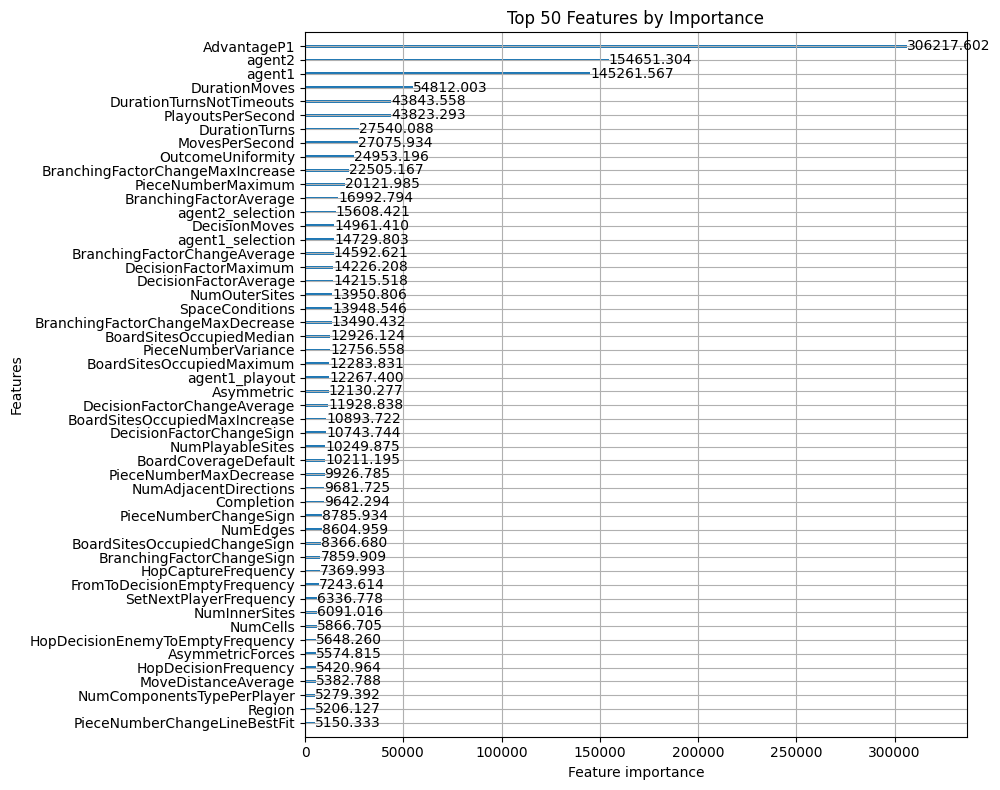

Fold 5 - RMSE: 0.41856185331856344
List of oof scores: [0.42815572462710627, 0.4175825446623493, 0.4252656709917196, 0.4155703003377357, 0.41856185331856344]
Average oof score: 0.42102721878749483


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4307
Score: 0.4396
Score: 0.4346
Score: 0.4312
Score: 0.4000
Average CV1 Score: 0.4272

CV2 OOF Scores:
Score: 0.4120
Score: 0.4045
Score: 0.4269
Score: 0.4395
Score: 0.4247
Average CV2 Score: 0.4215

CV3 OOF Scores:
Score: 0.4282
Score: 0.4176
Score: 0.4253
Score: 0.4156
Score: 0.4186
Average CV3 Score: 0.4210


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

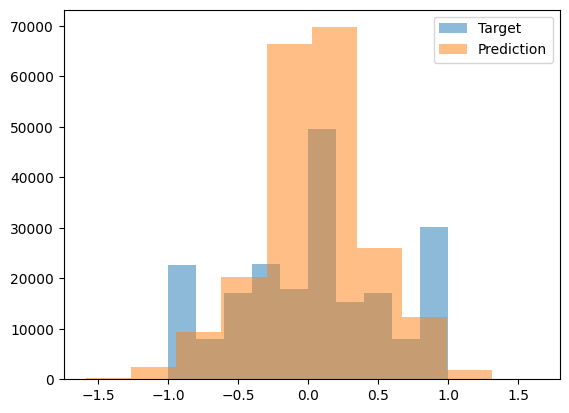

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.120249       │
│ 233235 ┆ -0.141434      │
│ 233236 ┆ -0.061569      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***